In [3]:
%%capture
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Audio_Sentiment_Analysis/iemocap/data

In [4]:
%%capture
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../../'))
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import pandas as pd
import tensorflow as tf
import librosa
import librosa.display
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier as RandomForest, HistGradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from Audio_Sentiment_Analysis.utils.Configuration import Configuration
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from PIL import Image
from tabulate import tabulate
from pprint import pprint
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

AUDIO_DIR = f"{os.path.abspath('./../../../')}/IEMOCAP_Dataset"
EXTRACTED_FEATURES_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/extracted_features_iemocap.csv"
CONFIG_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/config.json"
RAW_AUDIO_FILES = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/raw_audio_files.csv"
AUDIO_SPECTOGRAMS_DIR = './../data/spectograms/'

config = Configuration.load_json(CONFIG_FILE)
# !pip install autokeras
# !pip install --upgrade scipy==1.7.0
# !pip install auto-sklearn
import autokeras as ak
# from autosklearn.classification import AutoSklearnClassifier
# from autosklearn.regression import AutoSklearnRegressor

OneHotEncodingConfig = {'0': [1, 0, 0, 0], '1': [0, 1, 0, 0], '2': [0, 0, 1, 0], '3': [0, 0, 0, 1]}
plt.rcParams['figure.dpi'] = 300

In [2]:
def get_metrics(y_labels, y_pred, draw_corr_matrix=True):
    table = [
        ["Accuracy", round(metrics.accuracy_score(y_labels, y_pred) * 100, 2)],
        ["F1 score macro", round(metrics.f1_score(y_labels, y_pred, average='macro') * 100, 2)],
        ["Precision", round(metrics.precision_score(y_labels, y_pred, average='macro') * 100, 2)],
        ["Recall", round(metrics.recall_score(y_labels, y_pred, average='macro') * 100, 2)],
        ["Matthews corrcoef", round(metrics.matthews_corrcoef(y_labels, y_pred), 3)],
    ]
    print(tabulate(table, headers=["Metric","Value"]))

    if draw_corr_matrix:
        ticks =  ['0 - angry', '1 - happy', '2 - neutral', '3 - sad']
        cm = metrics.confusion_matrix(y_labels, y_pred)
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt="d", xticklabels=ticks, yticklabels=ticks)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Emotion Label")
        plt.ylabel("Real Emotion Label")
        plt.yticks(rotation=0)
        plt.show()

## Read the extracted features from the CSV

In [3]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
print(f"Number of Audio Files: {df.shape[0]}")
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df

Number of Audio Files: 10039


,Interaction,Gender,Duration,Emotion,Emotion_Id,Valence,Activation,Dominance,std_chroma_stft,mean_zcr,...,max_mfcc6,min_mfcc7,var_mfcc9,max_mfcc9,max_mfcc10,max_mfcc13,var_mfcc14,var_mfcc15,min_mfcc17,min_mfcc19
File,,,,,,,,,,,,,,,,,,,,,
Ses01F_impro01_F012,improvised,Female,2.750,angry,0,2.0,3.5,3.5,0.296270,0.082856,...,39.327560,-40.651329,42.375973,19.492970,19.512123,18.821735,47.666279,51.472340,-18.892769,-27.943581
Ses01F_impro04_F028,improvised,Female,2.010,angry,0,2.0,3.5,3.5,0.319851,0.086560,...,62.818893,-40.228039,84.092949,24.274593,11.059961,36.497154,29.247034,61.287384,-17.456673,-15.254041
Ses01F_impro04_F029,improvised,Female,3.160,angry,0,1.5,4.0,4.0,0.298296,0.085880,...,29.858166,-33.455795,164.847565,34.833263,22.882631,33.635147,118.356186,128.460770,-32.842518,-12.516586
Ses01F_impro04_F030,improvised,Female,3.185,angry,0,1.5,3.5,4.0,0.316109,0.106300,...,48.537384,-38.774422,178.178299,24.138340,11.319570,35.046803,183.465393,119.128494,-13.127378,-24.713459
Ses01F_impro04_F031,improvised,Female,4.400,angry,0,1.5,3.0,3.5,0.314387,0.065918,...,44.125771,-49.090309,100.364433,35.686844,29.594337,11.990172,68.253944,51.992161,-20.573139,-20.019981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ses05M_script03_2_M013,scripted,Male,9.340,other,10,2.0,3.5,4.0,0.314951,0.063627,...,58.600712,-46.007534,113.818436,32.636822,28.463696,25.335880,78.160225,66.925186,-27.014687,-21.044426
Ses05M_script03_2_M014,scripted,Male,4.150,other,10,1.5,3.5,4.0,0.315053,0.067145,...,73.493271,-54.896301,162.575638,31.630028,12.225033,33.560890,87.977707,42.288971,-24.003210,-19.897762
Ses05M_script03_2_M018,scripted,Male,2.170,other,10,3.5,3.0,3.0,0.302163,0.062219,...,51.708046,-34.321487,181.688660,23.869041,14.644627,14.957552,41.870499,43.103497,-20.033688,-19.955128


## Data used in SOA models

In [4]:
emotion_id_label = {
  0: "angry",
  1: "happy",
  2: "neutral",
  3: "sad",
}
df = df[df['Emotion'].isin({'angry', 'neutral', 'sad', 'happy', 'excited'})]
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

,,Emotion
,,count
Emotion,Emotion_Id,
angry,0,1103
happy,1,1636
neutral,3,1708
sad,2,1084


# Categorical Problem (anger, happiness (+ excited), neutral, sadness)

## Models

### Simple Random Forests

In [3]:
def categorical_cross_validation(get_new_model, cv=5, draw_corr_matrix=True):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)
    
    X = df.iloc[:,8:]
    y = df.iloc[:,4:5]
    all_y_pred = []
    all_y_labels = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        model = get_new_model()
        
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]

        model.fit(X_train, y_train.values.ravel())

        y_pred = model.predict(X_test)
        all_y_pred.extend(y_pred)
        y_test = np.reshape(y_test.values, y_pred.shape)
        all_y_labels.extend(y_test)

        fold_no = fold_no + 1

    get_metrics(all_y_labels, all_y_pred, draw_corr_matrix)

Metric               Value
-----------------  -------
Accuracy            60.37
F1 score macro      61.09
Precision           62.11
Recall              60.65
Matthews corrcoef    0.463


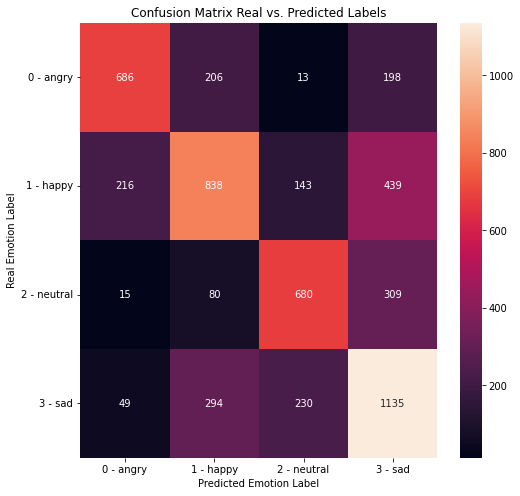

In [42]:
def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
categorical_cross_validation(get_new_model)

### Gradient Boosting Classifier

Metric               Value
-----------------  -------
Accuracy            59.34
F1 score macro      60.15
Precision           60.75
Recall              59.89
Matthews corrcoef    0.449


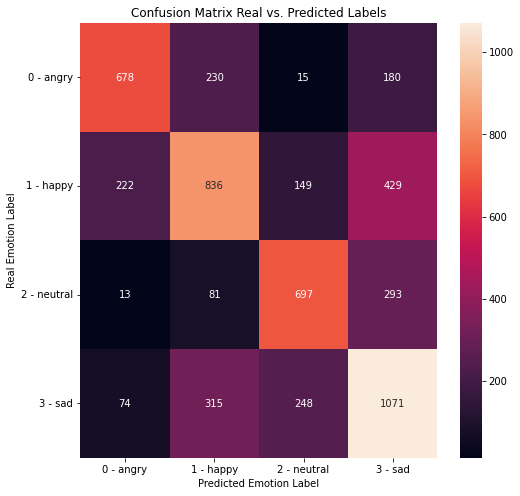

In [43]:
def get_new_model():
    return GradientBoostingClassifier(random_state=1, max_features=8)
categorical_cross_validation(get_new_model)

### Ada Boost Classifier

Metric               Value
-----------------  -------
Accuracy             60.15
F1 score macro       60.87
Precision            61.9
Recall               60.42
Matthews corrcoef     0.46


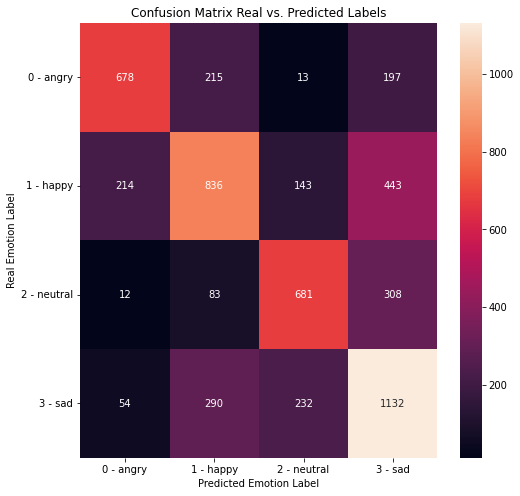

In [44]:
def get_new_model():
    return AdaBoostClassifier(random_state=1, base_estimator=RandomForest(n_estimators=512, n_jobs=-1, random_state=1))
categorical_cross_validation(get_new_model)


### Balanced Random Forest Classifier

Metric                Value
-----------------  --------
Accuracy           0.589586
F1 score macro     0.596052
Precision          0.591588
Recall             0.615141
Matthews corrcoef  0.455213


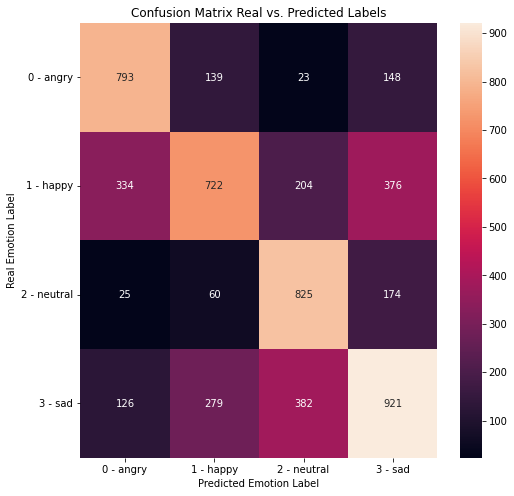

In [13]:
def get_new_model():
    return BalancedRandomForestClassifier(random_state=1, max_features=8)
categorical_cross_validation(get_new_model)

### AutoSKlearn

Training Fold 1...


/usr/local/lib/python3.7/dist-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41493 instead
  f"Port {expected} is already in use.\n"


Training Fold 2...
Training Fold 3...
Training Fold 4...
Training Fold 5...
Metric                  Value
-------------------  --------
Accuracy             0.603508
F1 score macro       0.611989
F1 score micro       0.603508
Precision            0.617442
Recall               0.611399
Hamming loss         0.396492
Matthews corrcoef    0.464214
Zero one loss        0.396492
Mean absolute error  0.63117


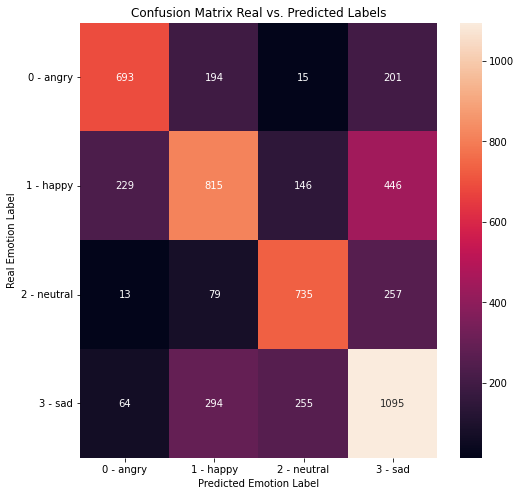

In [17]:
def categorical_cross_validation2(cv=5, draw_corr_matrix=True):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)
    
    X = df.iloc[:,8:]
    y = df.iloc[:,4:5]
    all_y_pred = []
    all_y_labels = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        model = AutoSklearnClassifier(time_left_for_this_task=900, per_run_time_limit=720, max_models_on_disc=None, n_jobs=-1, seed=1)
        
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]

        print(f"Training Fold {fold_no}...")

        model.fit(X_train, y_train.values.ravel())

        with open(f'ensemble_model_fold_{fold_no}.pkl', 'wb') as f:
            pickle.dump(model, f)

        y_pred = model.predict(X_test)
        all_y_pred.extend(y_pred)
        y_test = np.reshape(y_test.values, y_pred.shape)
        all_y_labels.extend(y_test)

        fold_no = fold_no + 1

    get_metrics(all_y_labels, all_y_pred, draw_corr_matrix)

categorical_cross_validation2()

In [36]:
def print_model_leaderboards():
  for i in range(1, 6):
    print(
        f'--------------------------Model of Fold {i} ----------------------------')
    with open(f'ensemble_model_fold_{i}.pkl', 'rb') as f:
        ensemble_model = pickle.load(f)
    print(ensemble_model.leaderboard())
    pprint(ensemble_model.show_models(), indent=4)

print_model_leaderboards()

--------------------------Model of Fold 1 ----------------------------
          rank  ensemble_weight                type      cost    duration
model_id                                                                 
2            1             0.04       random_forest  0.384247   18.723927
12           2             0.18       random_forest  0.384247    7.208884
11           3             0.16       random_forest  0.385616  317.518019
3            4             0.02   gradient_boosting  0.387671  261.969007
15           5             0.02       random_forest  0.391781   20.279643
19           6             0.06       random_forest  0.393151   31.602620
24           7             0.06   gradient_boosting  0.400685   11.521106
23           8             0.10                 lda  0.402055    9.769117
25           9             0.02   gradient_boosting  0.413014   16.518846
9           10             0.02       random_forest  0.415753   15.560822
13          11             0.02       ran

#### Testing the Highest Ranked Models of the Ensemble

Metric                  Value
-------------------  --------
Accuracy             0.603688
F1 score macro       0.610893
F1 score micro       0.603688
Precision            0.621107
Recall               0.606498
Hamming loss         0.396312
Matthews corrcoef    0.463218
Zero one loss        0.396312
Mean absolute error  0.623215


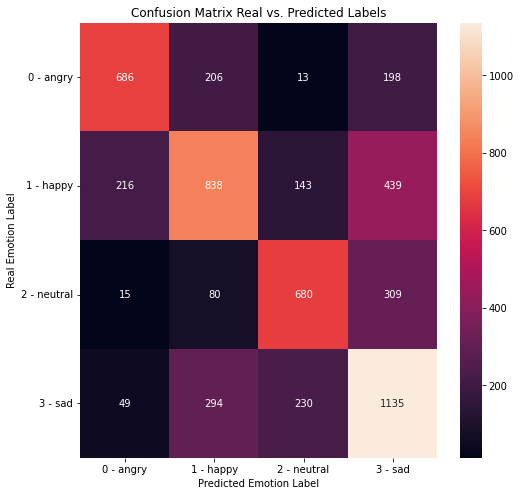

In [37]:
def get_new_model():
  return RandomForest(max_features=4, n_estimators=512, n_jobs=-1,
                       random_state=1, warm_start=True)
categorical_cross_validation(get_new_model)

Metric                  Value
-------------------  --------
Accuracy             0.55885
F1 score macro       0.568384
F1 score micro       0.55885
Precision            0.570003
Recall               0.568704
Hamming loss         0.44115
Matthews corrcoef    0.403341
Zero one loss        0.44115
Mean absolute error  0.683963


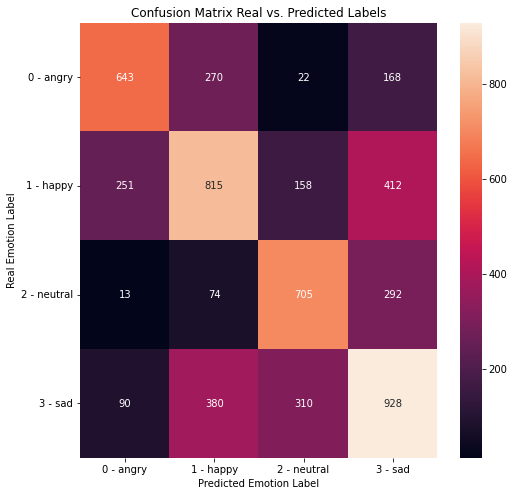

In [32]:
def get_new_model():
    return LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr',
                           tol=0.00010000000000000009)
categorical_cross_validation(get_new_model)

Metric                Value
-----------------  --------
Accuracy           0.6017
F1 score macro     0.609154
Precision          0.614036
Recall             0.606619
Matthews corrcoef  0.460297


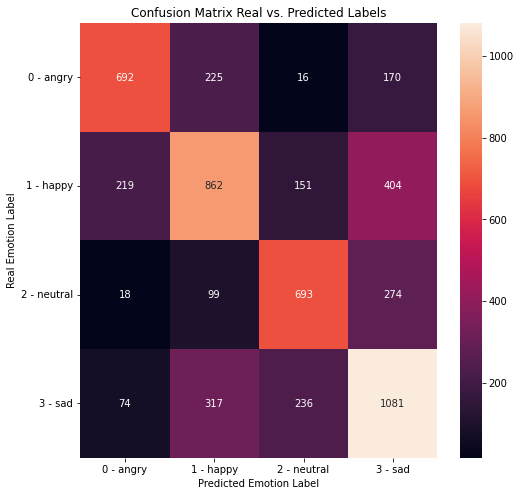

In [16]:
def get_new_model():
    return HistGradientBoostingClassifier(early_stopping=False,
                                          l2_regularization=2.188553300996835e-10,
                                          learning_rate=0.06138190336151616, max_iter=512,
                                          max_leaf_nodes=20, n_iter_no_change=0,
                                          random_state=1, validation_fraction=None,
                                          warm_start=True)
categorical_cross_validation(get_new_model)

### Convolution Neural Networks

In [ ]:
def build_model_0(input_shape=(24, 1), loss=MeanSquaredError(), optimizer=Adam(learning_rate=1e-5, epsilon=1e-6)):
    if loss.__class__ == SparseCategoricalCrossentropy().__class__:
        n_labels = 4
        metrics = ['accuracy']
        activation = 'softmax'
    else:
        n_labels = 3
        metrics = ['mae']
        activation = 'relu'

    model = Sequential()
    model.add(Conv1D(256, (5), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv1D(128, (5)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(n_labels, strides=1))

    model.add(Conv1D(128, (5)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Flatten())

    model.add(Dense(n_labels))

    model.add(Activation(activation))

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model
build_model_0(input_shape=(24,1)).summary(show_trainable=True)

Model: "sequential"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv1d (Conv1D)             (None, 20, 256)           1536      Y          
                                                                            
 batch_normalization (BatchN  (None, 20, 256)          1024      Y          
 ormalization)                                                              
                                                                            
 activation (Activation)     (None, 20, 256)           0         Y          
                                                                            
 conv1d_1 (Conv1D)           (None, 16, 128)           163968    Y          
                                                                            
 activation_1 (Activation)   (None, 16, 128)           0         Y          
                                                        

Metric                  Value
-------------------  --------
Accuracy             0.456156
F1 score macro       0.46223
F1 score micro       0.456156
Precision            0.485571
Recall               0.461326
Hamming loss         0.543844
Matthews corrcoef    0.264913
Zero one loss        0.543844
Mean absolute error  0.820286


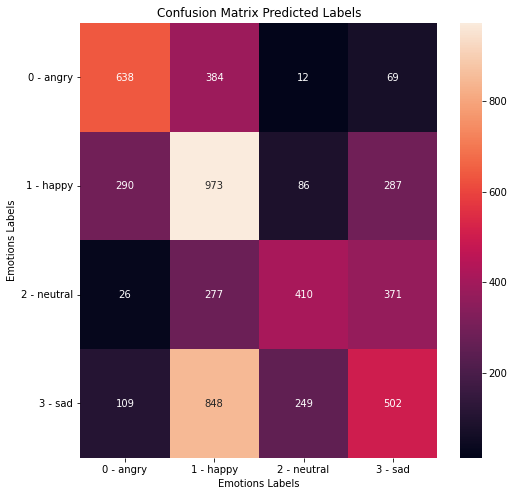

In [ ]:
def categorical_cross_validation(get_new_model, callbacks, no_epochs, batch_size, verbosity=1, num_folds=5, draw_corr_matrix=True):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
  fold_no = 1

  X = df.iloc[:, 8:]
  y = df.iloc[:, 4:5]

  all_y_pred = []
  all_y_labels = []

  for train, test in kfold.split(X, y):
    model = get_new_model(fold_no)

    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              callbacks=callbacks,
              workers=8)

    y_pred = model.predict(X_test)
    y_pred = [list(x).index(max(x)) for x in y_pred]
    all_y_pred.extend(y_pred)
    all_y_labels.extend(y_test.values)

    fold_no = fold_no + 1

  get_metrics(all_y_labels, all_y_pred, draw_corr_matrix)


callback = EarlyStopping(monitor='loss', patience=10)
no_epochs = 500
batch_size = 16

verbosity = 0
num_folds = 5


def get_new_model():
    learning_rate = 1e-5
    loss = SparseCategoricalCrossentropy()
    optimizer = Adam(learning_rate=learning_rate)
    return build_model_0(input_shape=(24, 1), loss=loss, optimizer=optimizer)


categorical_cross_validation(
    get_new_model, callback, no_epochs, batch_size, verbosity, num_folds)


### AutoKeras

In [ ]:
def categorical_cross_validation(get_new_model, no_epochs, batch_size, verbosity, num_folds):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
  fold_no = 1
  
  X = df.iloc[:,8:]
  y = df.iloc[:,4:5]

  for train, _ in kfold.split(X, y):
    model = get_new_model(fold_no)
    
    X_train, y_train = X.iloc[train], y.iloc[train]

    model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity,
                callbacks=[EarlyStopping()],
                workers=8)
  
    model.export_model()

    fold_no = fold_no + 1

no_epochs = 500
batch_size = 16

verbosity = 0
num_folds = 5

def get_new_model(fold_no):
    return ak.StructuredDataClassifier(overwrite=True, max_trials=100, seed=1, directory=f"categorical_keras_model_fold_{fold_no}")
categorical_cross_validation(no_epochs, batch_size, verbosity, num_folds)

#### Testing the Models

Metric                  Value
-------------------  --------
Accuracy             0.427952
F1 score macro       0.420636
F1 score micro       0.427952
Precision            0.478266
Recall               0.408264
Hamming loss         0.572048
Matthews corrcoef    0.210925
Zero one loss        0.572048
Mean absolute error  0.973423


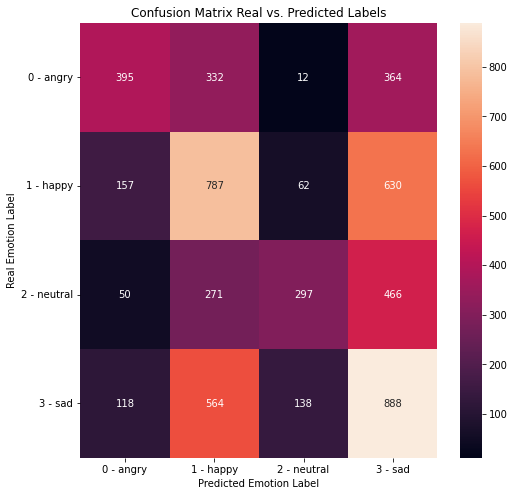

In [ ]:
def categorical_cross_validation(num_folds=5, draw_corr_matrix=True):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
  fold_no = 1

  X = df.iloc[:, 8:]
  y = df.iloc[:, 4:5]

  all_y_pred = []
  all_y_labels = []
  models_summary = []

  for _, test in kfold.split(X, y):
    # for linux
    # model = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/categorical_keras_model_fold_{fold_no}/structured_data_classifier/best_model"
    # for windows
    model = f"{os.path.abspath('./../../../')}\\Audio_Sentiment_Analysis\\iemocap\\model\\categorical_keras_model_fold_{fold_no}\\structured_data_classifier\\best_model"
    model = tf.keras.models.load_model(model, custom_objects=ak.CUSTOM_OBJECTS)
    models_summary.append(model.summary)

    X_test, y_test = X.iloc[test], y.iloc[test]

    y_pred = model.predict(X_test)
    y_pred = [list(x).index(max(x)) for x in y_pred]
    all_y_pred.extend(y_pred)
    all_y_labels.extend(y_test.values)

    fold_no = fold_no + 1

  get_metrics(all_y_labels, all_y_pred, draw_corr_matrix)
  return models_summary

models_summary = categorical_cross_validation()

#### Models

In [ ]:
def print_model_summaries(models_summary):
  for i, summary in enumerate(models_summary):
    print(
        f'--------------------------Model of Fold {i+1} ----------------------------')
    summary()
print_model_summaries(models_summary)

--------------------------Model of Fold 1 ----------------------------
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24)]              0         
                                                                 
 multi_category_encoding (Mu  (None, 24)               0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 24)               49        
 n)                                                              
                                                                 
 dense (Dense)               (None, 16)                400       
                                                                 
 re_lu (ReLU)                (None, 16)                0         
                                                        

### AutoKeras - Mel-Spectogram as the Input Feature

In [19]:
spec_df = pd.read_csv(RAW_AUDIO_FILES)
print(f"Number of Audio Files: {spec_df.shape[0]}")
spec_df = spec_df.set_index('File')
spec_df = spec_df[spec_df['Emotion'].isin({'angry', 'neutral', 'sad', 'happy', 'excited'})]
spec_df.loc[spec_df['Emotion'] == 'excited', 'Emotion'] = 'happy'
spec_df.loc[spec_df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
spec_df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

Number of Audio Files: 10039


,,Emotion
,,count
Emotion,Emotion_Id,
angry,0,1103
happy,1,1636
neutral,3,1708
sad,2,1084


In [20]:
AUTOTUNE = tf.data.AUTOTUNE

emotion_id_label = {
  0: "angry",
  1: "happy",
  2: "neutral",
  3: "sad",
}

def get_spec_and_label(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))
    y, sr = librosa.load(audio_file, sr=None, res_type='kaiser_fast')

    input_len = sr * 5
    y = y[:input_len]
    # Zero-padding for an audio waveform with less than 5 seconds.
    if (input_len > tf.shape(y)[0]):
        zero_padding = tf.zeros(
            [input_len] - tf.shape(y),
            dtype=tf.float32)
        y = tf.cast(y, dtype=tf.float32)
        y = tf.concat([y, zero_padding], 0)
        y = y.numpy()

    mel_spect = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=config.n_mels)
    mel_spect = np.reshape(mel_spect, -1)

    # for windows
    return mel_spect, spec_df.loc[f"/Users/mario/{audio_file[15:]}".replace("\\", "/")]["Emotion_Id"]
    # for linux
    # return mel_spect, spec_df.loc[audio_file]["Emotion_Id"]


def get_spec_and_label_oneHot(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))
    y, sr = librosa.load(audio_file, sr=None, res_type='kaiser_fast')

    input_len = sr * 5
    y = y[:input_len]
    # Zero-padding for an audio waveform with less than 5 seconds.
    if (input_len > tf.shape(y)[0]):
        zero_padding = tf.zeros(
            [input_len] - tf.shape(y),
            dtype=tf.float32)
        y = tf.cast(y, dtype=tf.float32)
        y = tf.concat([y, zero_padding], 0)
        y = y.numpy()

    mel_spect = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=config.n_mels)
    mel_spect = np.reshape(mel_spect, -1)

    # for windows
    return mel_spect, OneHotEncodingConfig[str(spec_df.loc[f"/Users/mario/{audio_file[15:]}".replace("\\", "/")]["Emotion_Id"])]
    # for linux
    # return mel_spect, OneHotEncodingConfig[str(spec_df.loc[audio_file]["Emotion_Id"])]

def data_loader(filename):
    features, labels = tf.py_function(
        get_spec_and_label, [filename], [tf.float32, tf.int64])
    return tf.reshape(features, [5024]), tf.reshape(labels, [1])


def data_loader_oneHot(filename):
    features, labels = tf.py_function(
        get_spec_and_label_oneHot, [filename], [tf.float32, tf.float32])
    return tf.reshape(features, [5024]), tf.reshape(labels, [4])


def preprocess_dataset(files, oneHotEncoding=False):
  # mac
    #   filenames_ds = tf.data.Dataset.list_files([str(file) for file in files.index.values])
  # windows
  filenames_ds = tf.data.Dataset.list_files(
      [f"C:\\Users\\Chico{str(file)[12:]}" for file in files.index.values])
  if oneHotEncoding:
    return filenames_ds.map(data_loader_oneHot, num_parallel_calls=AUTOTUNE)

  return filenames_ds.map(data_loader, num_parallel_calls=AUTOTUNE)


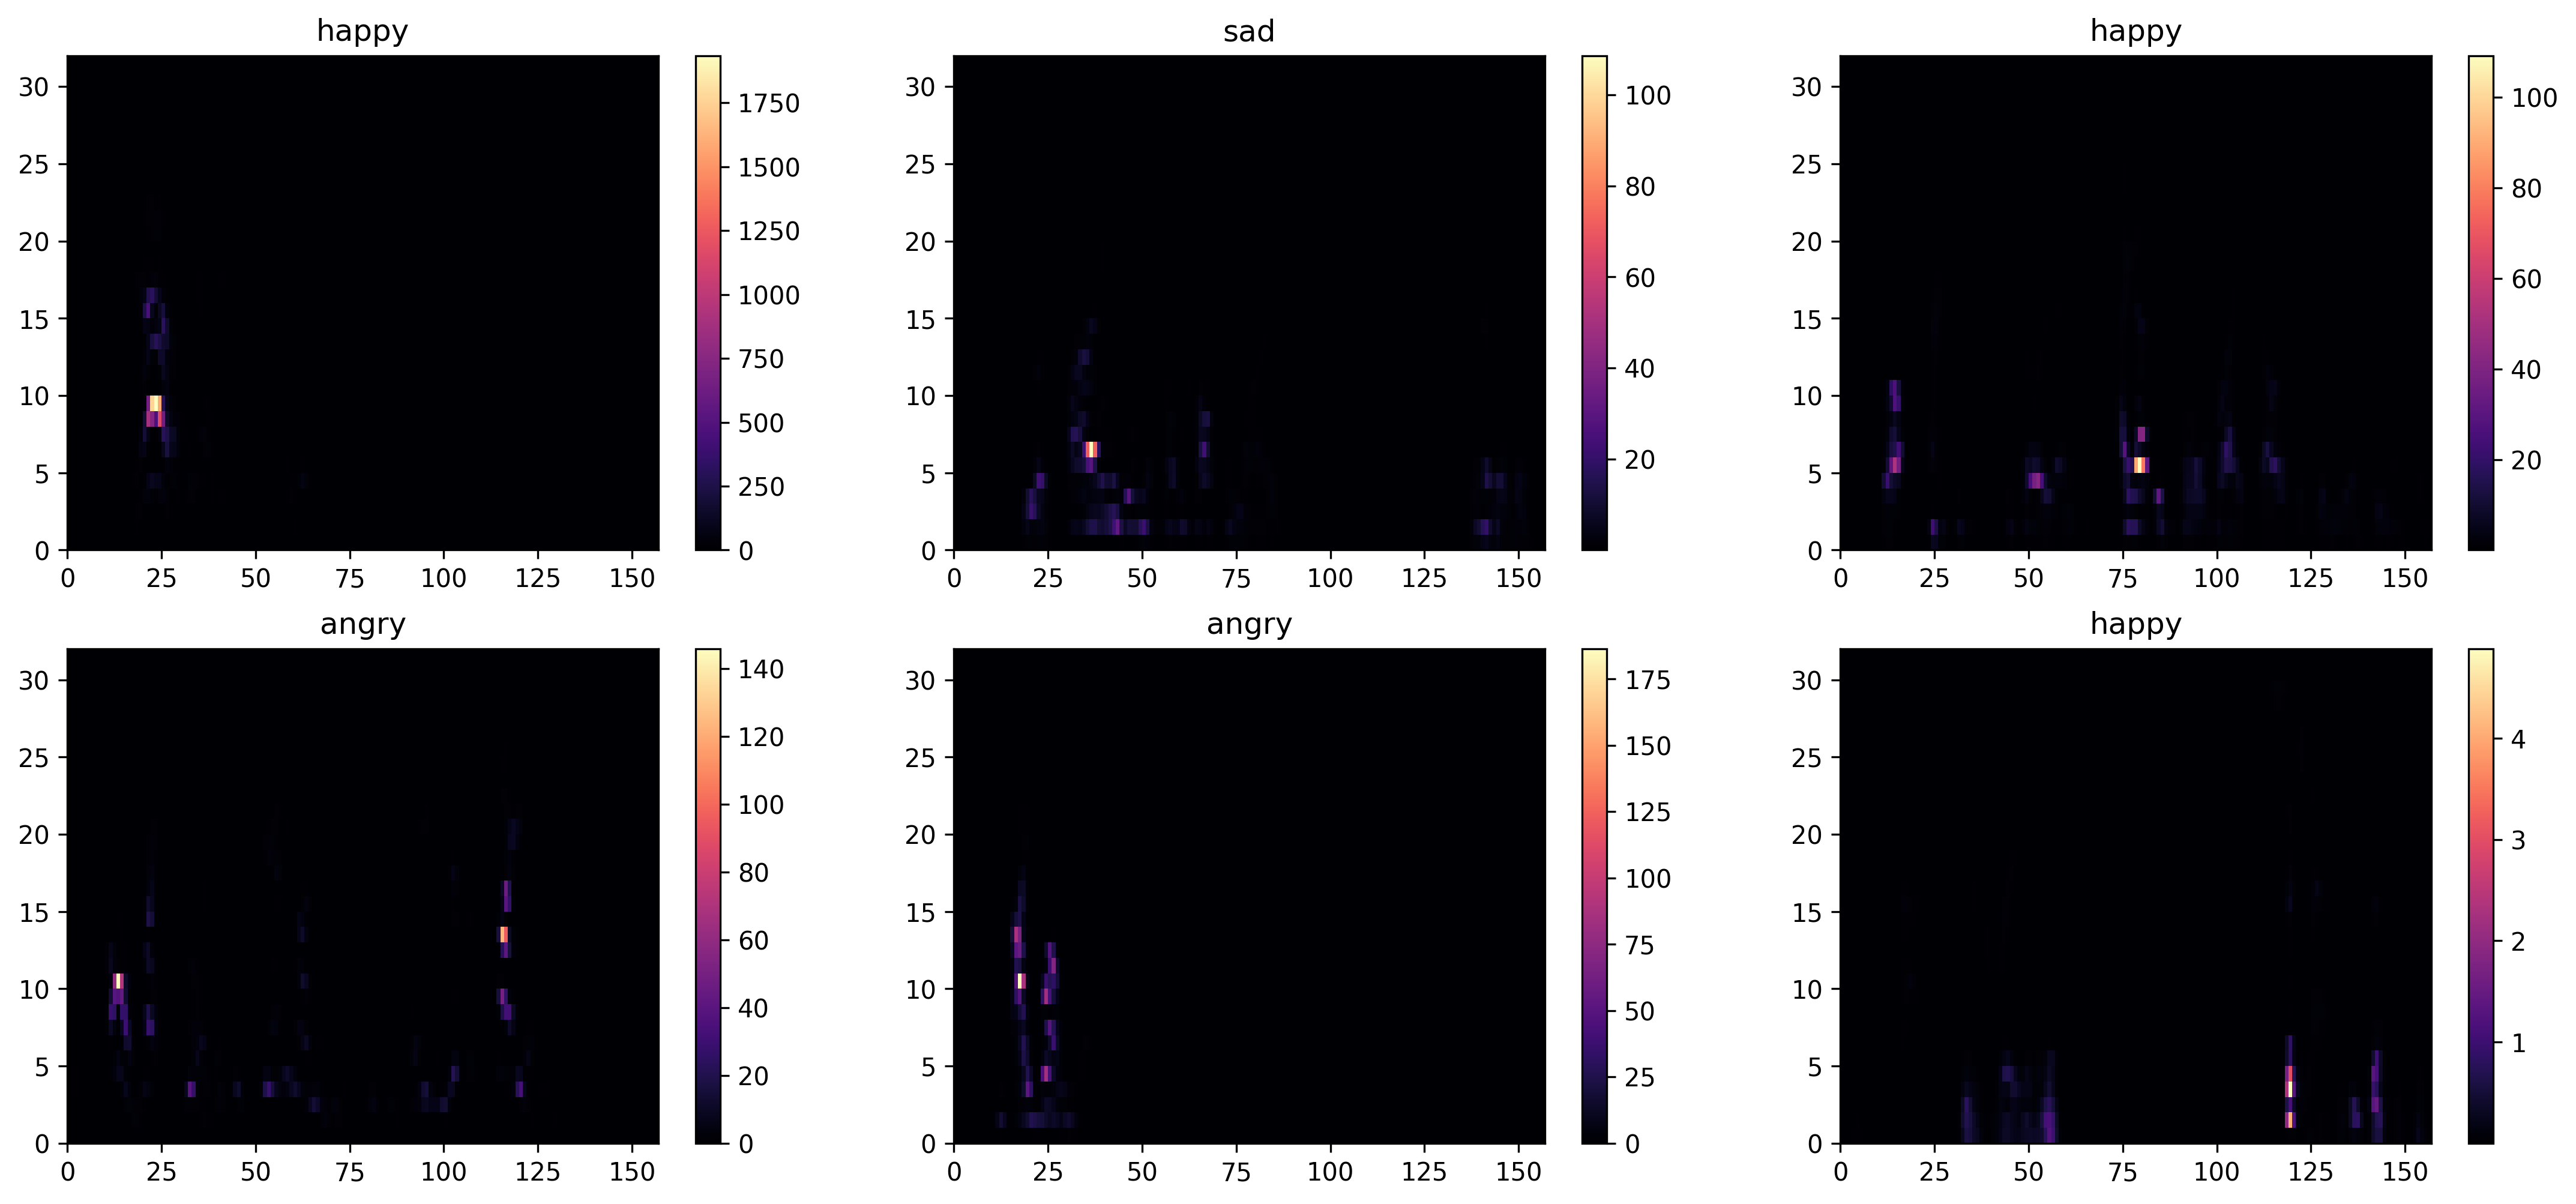

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

for i, (audio, label) in enumerate(preprocess_dataset(spec_df).take(6)):
  r = i // 3
  c = i % 3
  ax = axes[r][c]
  spec = audio.numpy()
  spec = np.reshape(spec, (32, 157))
  im = ax.pcolormesh(spec, cmap="magma")
  fig.colorbar(im, ax=ax)
  label = label.numpy()[0]
  ax.set_title(emotion_id_label[label])

plt.show()

In [ ]:
def categorical_cross_validation(callback, no_epochs, batch_size, verbosity, num_folds):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
  fold_no = 1
  
  X = spec_df.iloc[:]
  y = spec_df.iloc[:,4:5]

  for train, test in kfold.split(X, y):
    model = ak.StructuredDataClassifier(overwrite=True, max_trials=5, seed=1, directory=f"spec_categorical_keras_model_fold_{fold_no}")

    X_train = X.iloc[train]

    train_ds = preprocess_dataset(X_train)
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.cache().prefetch(AUTOTUNE)

    model.fit(train_ds,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity,
                callbacks=[callback],
                workers=8)

    fold_no = fold_no + 1

no_epochs = 50
batch_size = 16

callback = EarlyStopping(monitor='loss', patience=10)

verbosity = 0
num_folds = 5

categorical_cross_validation(callback, no_epochs, batch_size, verbosity, num_folds)

#### Testing the Models

Metric                  Value
-------------------  --------
Accuracy             0.468128
F1 score macro       0.467898
F1 score micro       0.468128
Precision            0.472378
Recall               0.469612
Hamming loss         0.531872
Matthews corrcoef    0.281344
Zero one loss        0.531872
Mean absolute error  0.820072


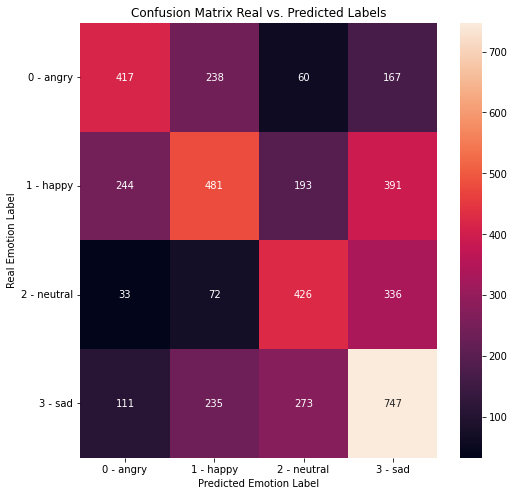

In [ ]:
def categorical_cross_validation(num_folds=5, draw_corr_matrix=True):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
  all_y_pred = []
  all_y_labels = []
  models_summary = []
  fold_no = 1

  X = spec_df.iloc[:, ]
  y = spec_df.iloc[:, 4:5]

  for _, test in kfold.split(X, y):
    model = f"{os.path.abspath('./../../../')}\\Audio_Sentiment_Analysis\\iemocap\\model\\spec_categorical_keras_model_fold_{fold_no}\\structured_data_classifier\\best_model"
    model = tf.keras.models.load_model(model, custom_objects=ak.CUSTOM_OBJECTS)
    models_summary.append(model.summary)

    X_test = X.iloc[test]

    test_ds = preprocess_dataset(X_test, True)
    test_ds = test_ds.batch(16)
    test_ds = test_ds.cache().prefetch(AUTOTUNE)

    for spec, label in test_ds.take(len(test_ds)):
      y_pred = model.predict(spec.numpy())
      all_y_pred.extend([list(x).index(max(x)) for x in y_pred])
      all_y_labels.extend([list(x).index(max(x)) for x in label.numpy()])

    fold_no = fold_no + 1

  get_metrics(all_y_labels, all_y_pred, draw_corr_matrix)
  return models_summary

models_summary = categorical_cross_validation()

#### Models

In [ ]:
print_model_summaries(models_summary)

--------------------------Model of Fold 1 ----------------------------
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5024)]            0         
                                                                 
 multi_category_encoding (Mu  (None, 5024)             0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 5024)             10049     
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                160800    
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                        

### AutoKeras - Mel-Spectogram as a Feature + Previous Selected Features

In [ ]:
def get_spec_and_label(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))
    y, sr = librosa.load(audio_file, sr=None, res_type='kaiser_fast')

    input_len = sr * 5
    y = y[:input_len]
    # Zero-padding for an audio waveform with less than 5 seconds.
    if (input_len > tf.shape(y)[0]):
        zero_padding = tf.zeros(
            [input_len] - tf.shape(y),
            dtype=tf.float32)
        y = tf.cast(y, dtype=tf.float32)
        y = tf.concat([y, zero_padding], 0)
        y = y.numpy()

    mel_spect = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=config.n_mels)
    mel_spect = np.reshape(mel_spect, -1)
    
    audio_idx = audio_file.split("\\")[-1][:-4]
    # for linux
    # audio_idx = audio_file.split("/")[-1][:-4]
    audio_features = df.loc[audio_idx][8:]
    audio_features = np.reshape(audio_features, -1)

    # for windows
    return np.concatenate((audio_features, mel_spect), axis=0), spec_df.loc[f"/Users/mario/{audio_file[15:]}".replace("\\", "/")]["Emotion_Id"]
    # for linux
    # return mel_spect, spec_df.loc[audio_file]["Emotion_Id"]


def get_spec_and_label_oneHot(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))
    y, sr = librosa.load(audio_file, sr=None, res_type='kaiser_fast')

    input_len = sr * 5
    y = y[:input_len]
    # Zero-padding for an audio waveform with less than 5 seconds.
    if (input_len > tf.shape(y)[0]):
        zero_padding = tf.zeros(
            [input_len] - tf.shape(y),
            dtype=tf.float32)
        y = tf.cast(y, dtype=tf.float32)
        y = tf.concat([y, zero_padding], 0)
        y = y.numpy()

    mel_spect = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=config.n_mels)
    mel_spect = np.reshape(mel_spect, -1)
    # for windows
    audio_idx = audio_file.split("\\")[-1][:-4]
    # for linux
    # audio_idx = audio_file.split("/")[-1][:-4]
    audio_features = df.loc[audio_idx][8:]
    audio_features = np.reshape(audio_features, -1)

    # for windows
    return np.concatenate((audio_features, mel_spect), axis=0), OneHotEncodingConfig[str(spec_df.loc[f"/Users/mario/{audio_file[15:]}".replace("\\", "/")]["Emotion_Id"])]
    # for linux
    # return np.concatenate((audio_features, mel_spect), axis=0), OneHotEncodingConfig[str(spec_df.loc[audio_file]["Emotion_Id"])]


def data_loader(filename):
    features, labels = tf.py_function(
        get_spec_and_label, [filename], [tf.float32, tf.int64])
    return tf.reshape(features, [5048]), tf.reshape(labels, [1])


def data_loader_oneHot(filename):
    features, labels = tf.py_function(
        get_spec_and_label_oneHot, [filename], [tf.float32, tf.float32])
    return tf.reshape(features, [5048]), tf.reshape(labels, [4])


In [ ]:
def categorical_cross_validation(callback, no_epochs, batch_size, verbosity, num_folds):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)

  X = spec_df.iloc[:]
  y = spec_df.iloc[:, 4:5]

  fold_no = 1
  for train, _ in kfold.split(X, y):
    model = ak.StructuredDataClassifier(
        overwrite=True, max_trials=5, seed=1, directory=f"feat_and_spec_categorical_keras_model_fold_{fold_no}")

    X_train = X.iloc[train]

    train_ds = preprocess_dataset(X_train)
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.cache().prefetch(AUTOTUNE)

    model.fit(train_ds,
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              callbacks=[callback],
              workers=8)

    fold_no = fold_no + 1

no_epochs = 50
batch_size = 16

callback = EarlyStopping(monitor='loss', patience=10)

verbosity = 0
num_folds = 5

categorical_cross_validation(
    callback, no_epochs, batch_size, verbosity, num_folds)


#### Testing the Models

Metric                  Value
-------------------  --------
Accuracy             0.504972
F1 score macro       0.508452
F1 score micro       0.504972
Precision            0.50788
Recall               0.519167
Hamming loss         0.495028
Matthews corrcoef    0.336131
Zero one loss        0.495028
Mean absolute error  0.774905


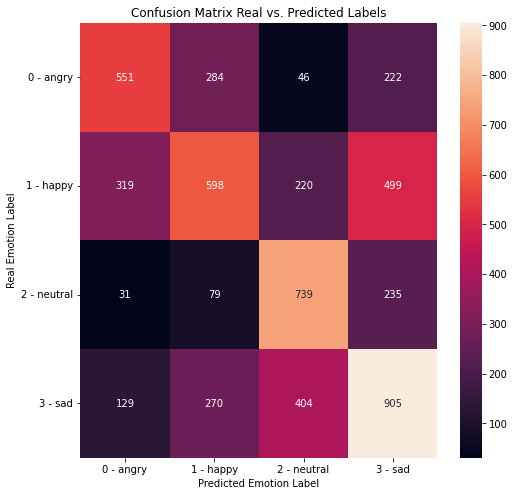

In [ ]:
def categorical_cross_validation(num_folds=5, draw_corr_matrix=True):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
  all_y_pred = []
  all_y_labels = []
  models_summary = []
  fold_no = 1

  X = spec_df.iloc[:, ]
  y = spec_df.iloc[:, 4:5]

  for _, test in kfold.split(X, y):
    model = f"{os.path.abspath('./../../../')}\\Audio_Sentiment_Analysis\\iemocap\\model\\feat_and_spec_categorical_keras_model_fold_{fold_no}\\structured_data_classifier\\best_model"
    model = tf.keras.models.load_model(model, custom_objects=ak.CUSTOM_OBJECTS)
    models_summary.append(model.summary)

    X_test = X.iloc[test]

    test_ds = preprocess_dataset(X_test, True)
    test_ds = test_ds.batch(16)
    test_ds = test_ds.cache().prefetch(AUTOTUNE)

    for spec, label in test_ds.take(len(test_ds)):
      y_pred = model.predict(spec.numpy())
      all_y_pred.extend([list(x).index(max(x)) for x in y_pred])
      all_y_labels.extend([list(x).index(max(x)) for x in label.numpy()])

    fold_no = fold_no + 1

  get_metrics(all_y_labels, all_y_pred, draw_corr_matrix)

  return models_summary

models_summary = categorical_cross_validation()

#### Models

In [ ]:
print_model_summaries(models_summary)

--------------------------Model of Fold 1 ----------------------------
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5048)]            0         
                                                                 
 multi_category_encoding (Mu  (None, 5048)             0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 5048)             10097     
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                161568    
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                        

### CNN - Takes too long to run on my PC

In [ ]:
def categorical_cross_validation(get_new_model, callback, no_epochs, batch_size, verbosity, num_folds):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)

  all_y_pred = []
  all_y_labels = []

  X = spec_df.iloc[:]
  y = spec_df.iloc[:, 4:5]

  fold_no = 1
  for train, test in kfold.split(X, y):
    model = get_new_model()

    X_train = X.iloc[train]

    train_ds = preprocess_dataset(X_train)
    train_ds = train_ds.batch(16)
    train_ds = train_ds.cache().prefetch(AUTOTUNE)

    print(f'Training for fold {fold_no} ...')

    model.fit(train_ds,
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              callbacks=[callback],
              workers=8)

    X_test = X.iloc[test]

    test_ds = preprocess_dataset(X_test, True)
    test_ds = test_ds.batch(16)
    test_ds = test_ds.cache().prefetch(AUTOTUNE)

    for spec, label in test_ds.take(len(test_ds)):
      y_pred = model.predict(spec.numpy())
      all_y_pred.extend([list(x).index(max(x)) for x in y_pred])
      all_y_labels.extend([list(x).index(max(x)) for x in label.numpy()])

    fold_no = fold_no + 1

  get_metrics(all_y_labels, all_y_pred, True)


callback = EarlyStopping(monitor='loss', patience=10)
no_epochs = 50
batch_size = 64

verbosity = 1
num_folds = 5


def get_new_model():
  learning_rate = 1e-5
  loss = SparseCategoricalCrossentropy()
  optimizer = Adam(learning_rate=learning_rate)
  return build_model_0(input_shape=(5048, 1), loss=loss, optimizer=optimizer)


categorical_cross_validation(
    get_new_model, callback, no_epochs, batch_size, verbosity, num_folds)


## Spectogram as a Feature

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
spec_df = pd.read_csv(RAW_AUDIO_FILES)
spec_df = spec_df.set_index('File')
spec_df = spec_df[spec_df['Emotion'].isin(
    {'angry', 'neutral', 'sad', 'happy', 'excited'})]
spec_df.loc[spec_df['Emotion'] == 'excited', 'Emotion'] = 'happy'
spec_df.loc[spec_df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
print(f"Number of Audio Files: {spec_df.shape[0]}")
print(spec_df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}))


def get_spec_and_label(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))
    filename = audio_file.split('\\')[-1][:-4]

    with open(f'{AUDIO_SPECTOGRAMS_DIR}{filename}.pickle', 'rb') as f:
        y = pickle.load(f)

    # for windows
    return y, spec_df.loc[f"/Users/mario/{audio_file[15:]}".replace("\\", "/")]["Emotion_Id"]
    # for linux
    # return mel_spect, spec_df.loc[audio_file]["Emotion_Id"]


def get_spec_and_label_oneHot(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))
    filename = audio_file.split('\\')[-1][:-4]

    with open(f'{AUDIO_SPECTOGRAMS_DIR}{filename}.pickle', 'rb') as f:
        y = pickle.load(f)

    # for windows
    return y, OneHotEncodingConfig[str(spec_df.loc[f"/Users/mario/{audio_file[15:]}".replace("\\", "/")]["Emotion_Id"])]
    # for linux
    # return mel_spect, OneHotEncodingConfig[str(spec_df.loc[audio_file]["Emotion_Id"])]


def data_loader(filename):
    features, labels = tf.py_function(
        get_spec_and_label, [filename], [tf.float32, tf.int64])
    return tf.reshape(features, [256, 256]), tf.reshape(labels, [1])


def data_loader_oneHot(filename):
    features, labels = tf.py_function(
        get_spec_and_label_oneHot, [filename], [tf.float32, tf.float32])
    return tf.reshape(features, [256, 256]), tf.reshape(labels, [4])


def preprocess_dataset(files, oneHotEncoding=False):
  # mac
    #   filenames_ds = tf.data.Dataset.list_files([str(file) for file in files.index.values])
  # windows
  filenames_ds = tf.data.Dataset.list_files(
      [f"C:\\Users\\Chico{str(file)[12:]}" for file in files.index.values])
  if oneHotEncoding:
    return filenames_ds.map(data_loader_oneHot, num_parallel_calls=AUTOTUNE)

  return filenames_ds.map(data_loader, num_parallel_calls=AUTOTUNE)


Number of Audio Files: 5531
                   Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
happy   1             1636
neutral 3             1708
sad     2             1084


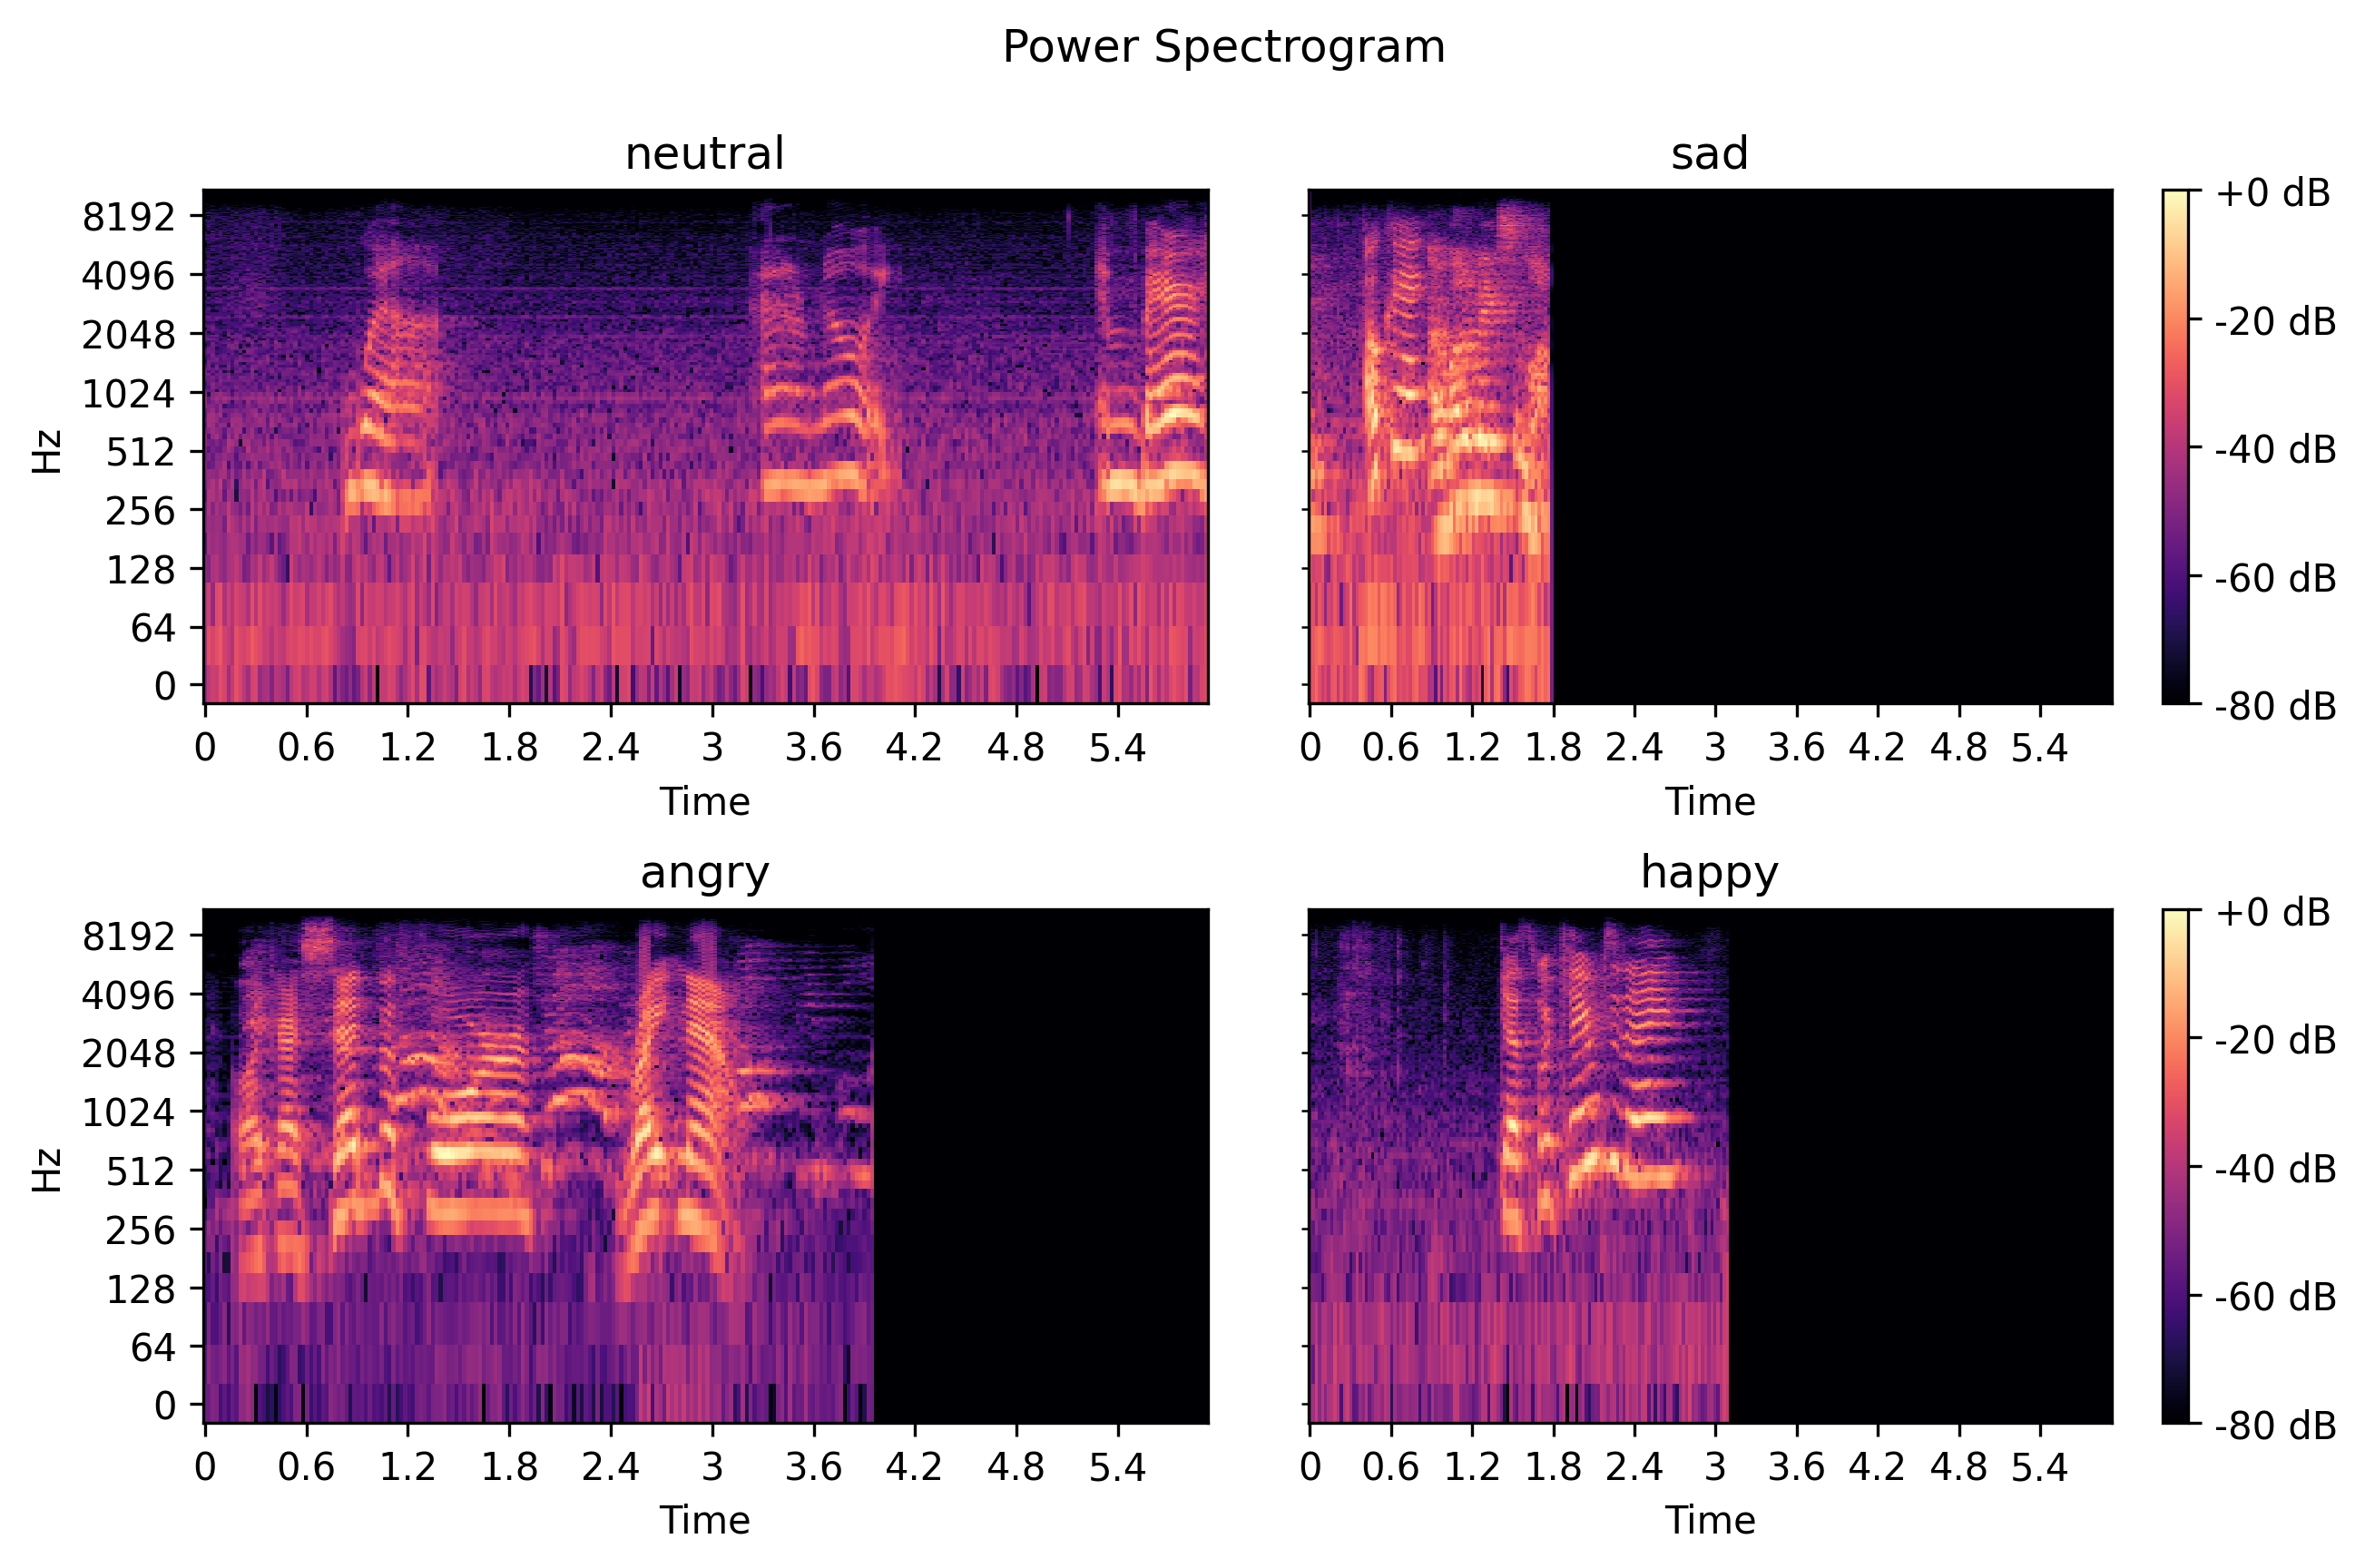

In [6]:
emotion_id_label = {
    0: "angry",
    1: "happy",
    2: "neutral",
    3: "sad",
}

fig, axes = plt.subplots(2, 2, figsize=(10, 6), constrained_layout=False)
fig.subplots_adjust(wspace=0.1)
fig.subplots_adjust(hspace=0.4)

labels = set()
i = 0
for audio, label in preprocess_dataset(spec_df).take(50):
  label = label.numpy()[0]
  if i == 4:
    break
  if label in labels:
    continue
  r = i // 2
  c = i % 2
  ax = axes[r][c]
  spec = audio.numpy()
  img = librosa.display.specshow(librosa.amplitude_to_db(
      spec, ref=np.max), y_axis='log', x_axis='time', ax=ax)
  if c == 1:
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
    ax.set_ylabel("")
    ax.set_yticks([])
  ax.set_title(emotion_id_label[label])
  labels.add(label)
  i += 1

fig.suptitle('Power Spectrogram')
plt.show()


In [7]:
def build_model_1(input_shape, loss, optimizer):
    model = Sequential()
    model.add(Conv1D(32, 8, strides=2, padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(64, 6, strides=2, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(128, 6, strides=3, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(128, 4, strides=2, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(128, 4, strides=2, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(256, 4, strides=2, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(256, 4, strides=2, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Dropout(0.25))
    model.add(Dense(4))
    model.add(Activation('softmax'))
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model


def get_new_model():
    input_shape = (256, 256)
    learning_rate = 1e-3
    loss = SparseCategoricalCrossentropy()
    optimizer = Adam(learning_rate=learning_rate)
    return build_model_1(input_shape, loss, optimizer)


get_new_model().summary(show_trainable=True)


Model: "sequential"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv1d (Conv1D)             (None, 128, 32)           65568     Y          
                                                                            
 activation (Activation)     (None, 128, 32)           0         Y          
                                                                            
 batch_normalization (BatchN  (None, 128, 32)          128       Y          
 ormalization)                                                              
                                                                            
 conv1d_1 (Conv1D)           (None, 64, 64)            12352     Y          
                                                                            
 activation_1 (Activation)   (None, 64, 64)            0         Y          
                                                        

Training for fold 1 ...
Training for fold 2 ...
Training for fold 3 ...
Training for fold 4 ...
Training for fold 5 ...
Metric               Value
-----------------  -------
Accuracy            48.15
F1 score macro      48.25
Precision           50.53
Recall              47.24
Matthews corrcoef    0.291


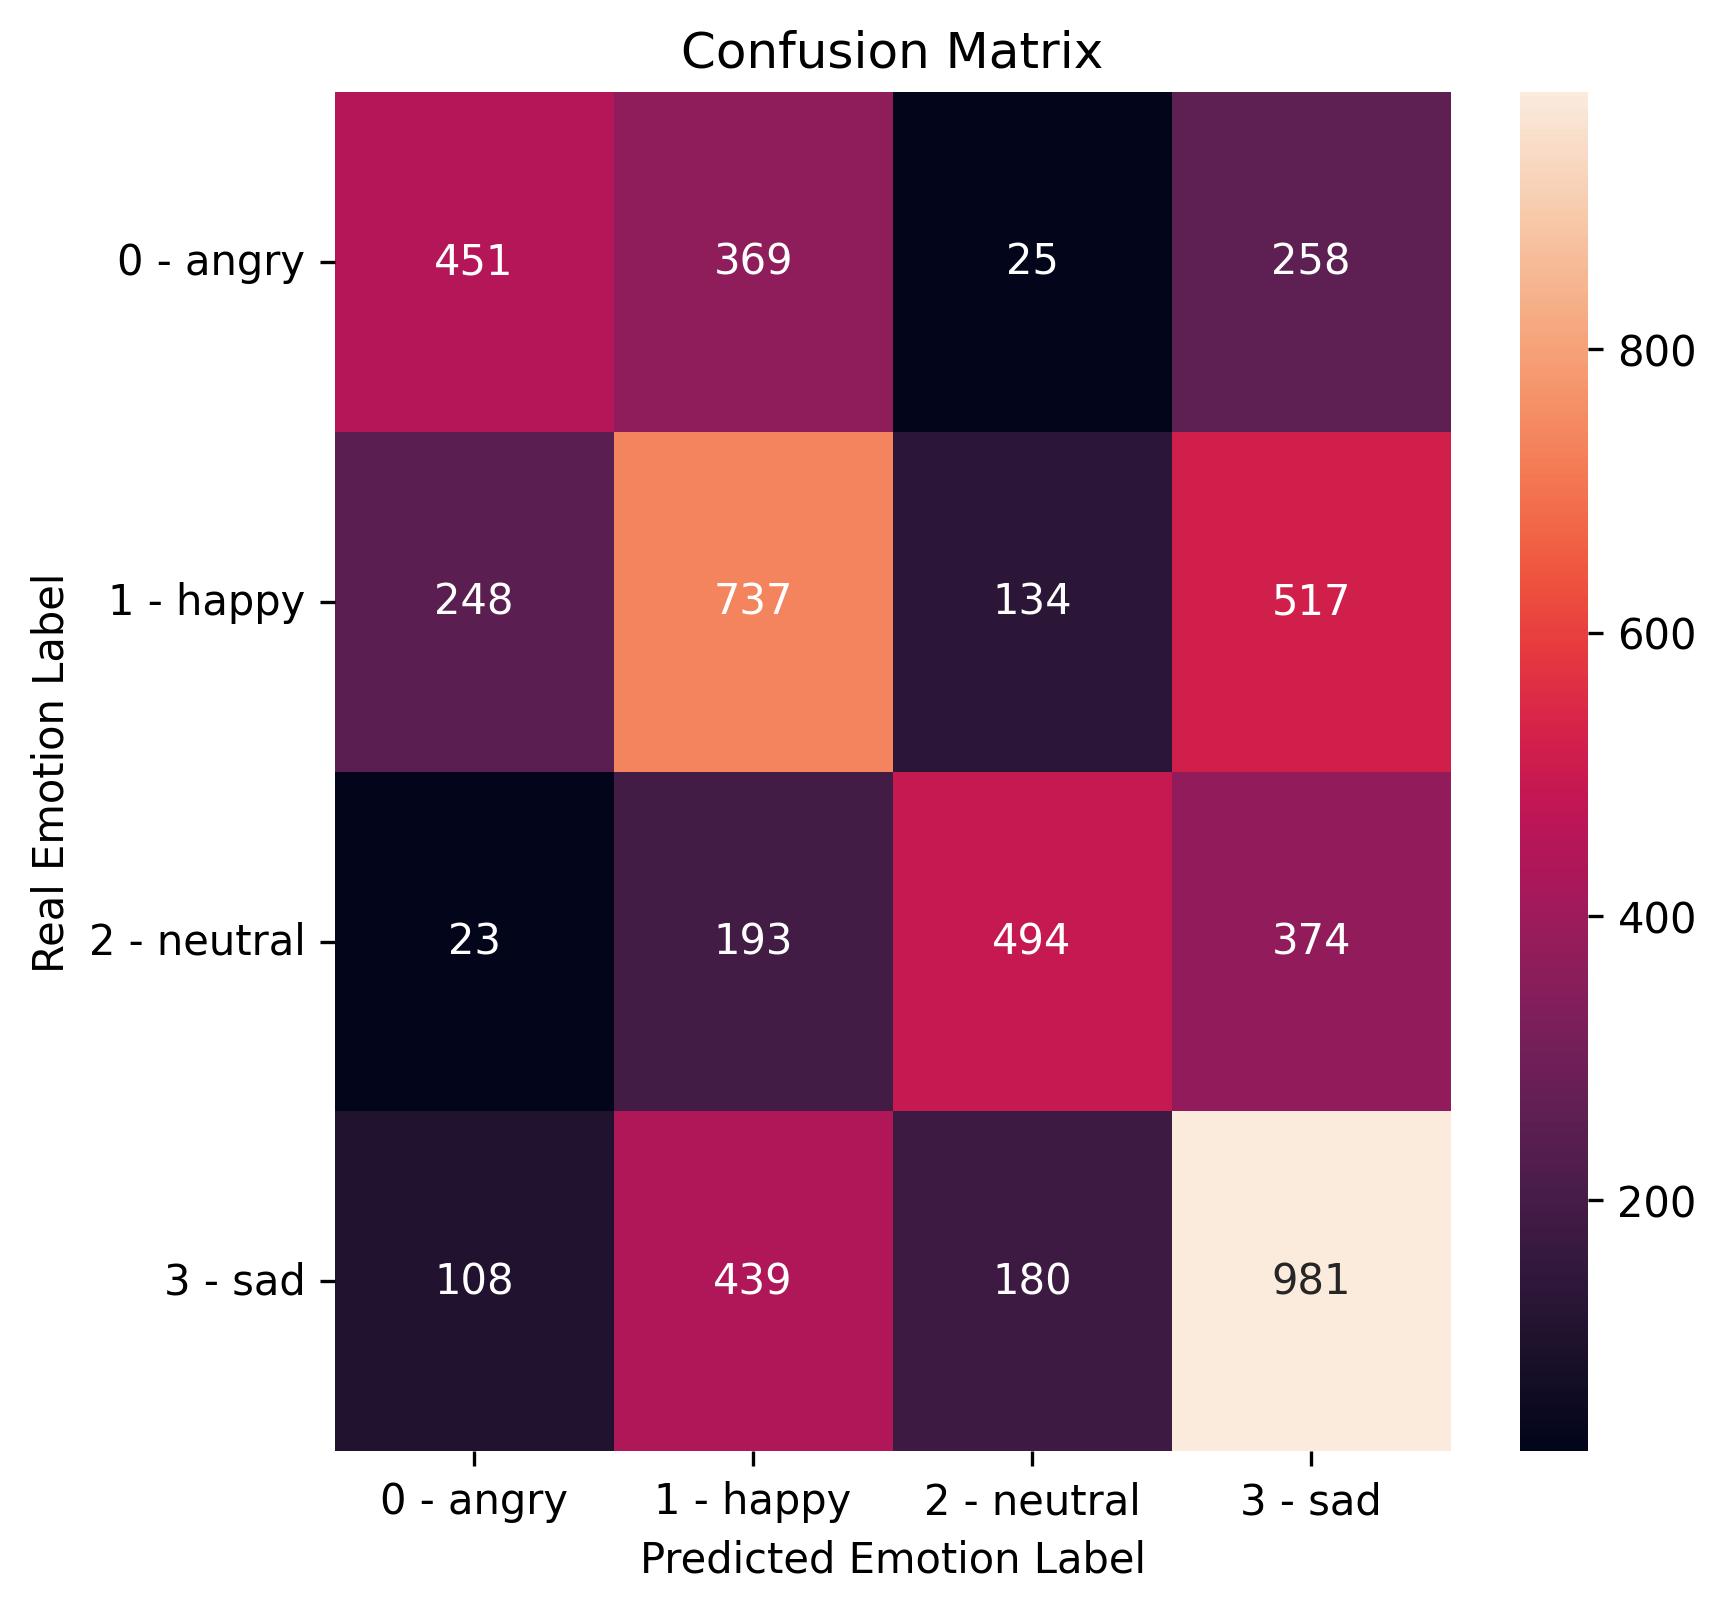

In [9]:
def categorical_cross_validation(get_new_model, callback, no_epochs, batch_size, verbosity, num_folds):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)

  all_y_pred = []
  all_y_labels = []

  X = spec_df.iloc[:]
  y = spec_df.iloc[:, 4:5]

  fold_no = 1
  for train, test in kfold.split(X, y):
    model = get_new_model()

    train_ds = X.iloc[train]
    train_ds = preprocess_dataset(train_ds)
    train_ds = train_ds.batch(64)
    train_ds = train_ds.cache().prefetch(AUTOTUNE)

    print(f'Training for fold {fold_no} ...')

    model.fit(train_ds,
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              callbacks=[callback],
              workers=8)

    test_ds = X.iloc[test]
    test_ds = preprocess_dataset(test_ds, True)
    test_ds = test_ds.batch(64)
    test_ds = test_ds.cache().prefetch(AUTOTUNE)

    for spec, label in test_ds.take(len(test_ds)):
      y_pred = model.predict(spec.numpy())
      all_y_pred.extend([list(x).index(max(x)) for x in y_pred])
      all_y_labels.extend([list(x).index(max(x)) for x in label.numpy()])

    fold_no = fold_no + 1

  return all_y_labels, all_y_pred

callback = EarlyStopping(monitor='loss', patience=10)
no_epochs = 50
batch_size = 128

verbosity = 0
num_folds = 5

y_labels = categorical_cross_validation(
    get_new_model, callback, no_epochs, batch_size, verbosity, num_folds)
all_y_labels, all_y_pred = y_labels
get_metrics(all_y_labels, all_y_pred, True)


## MFCC as Feature

Training for fold 1 ...
Training for fold 2 ...
Training for fold 3 ...
Training for fold 4 ...
Training for fold 5 ...
Metric               Value
-----------------  -------
Accuracy            46.47
F1 score macro      46.84
Precision           46.99
Recall              46.79
Matthews corrcoef    0.274


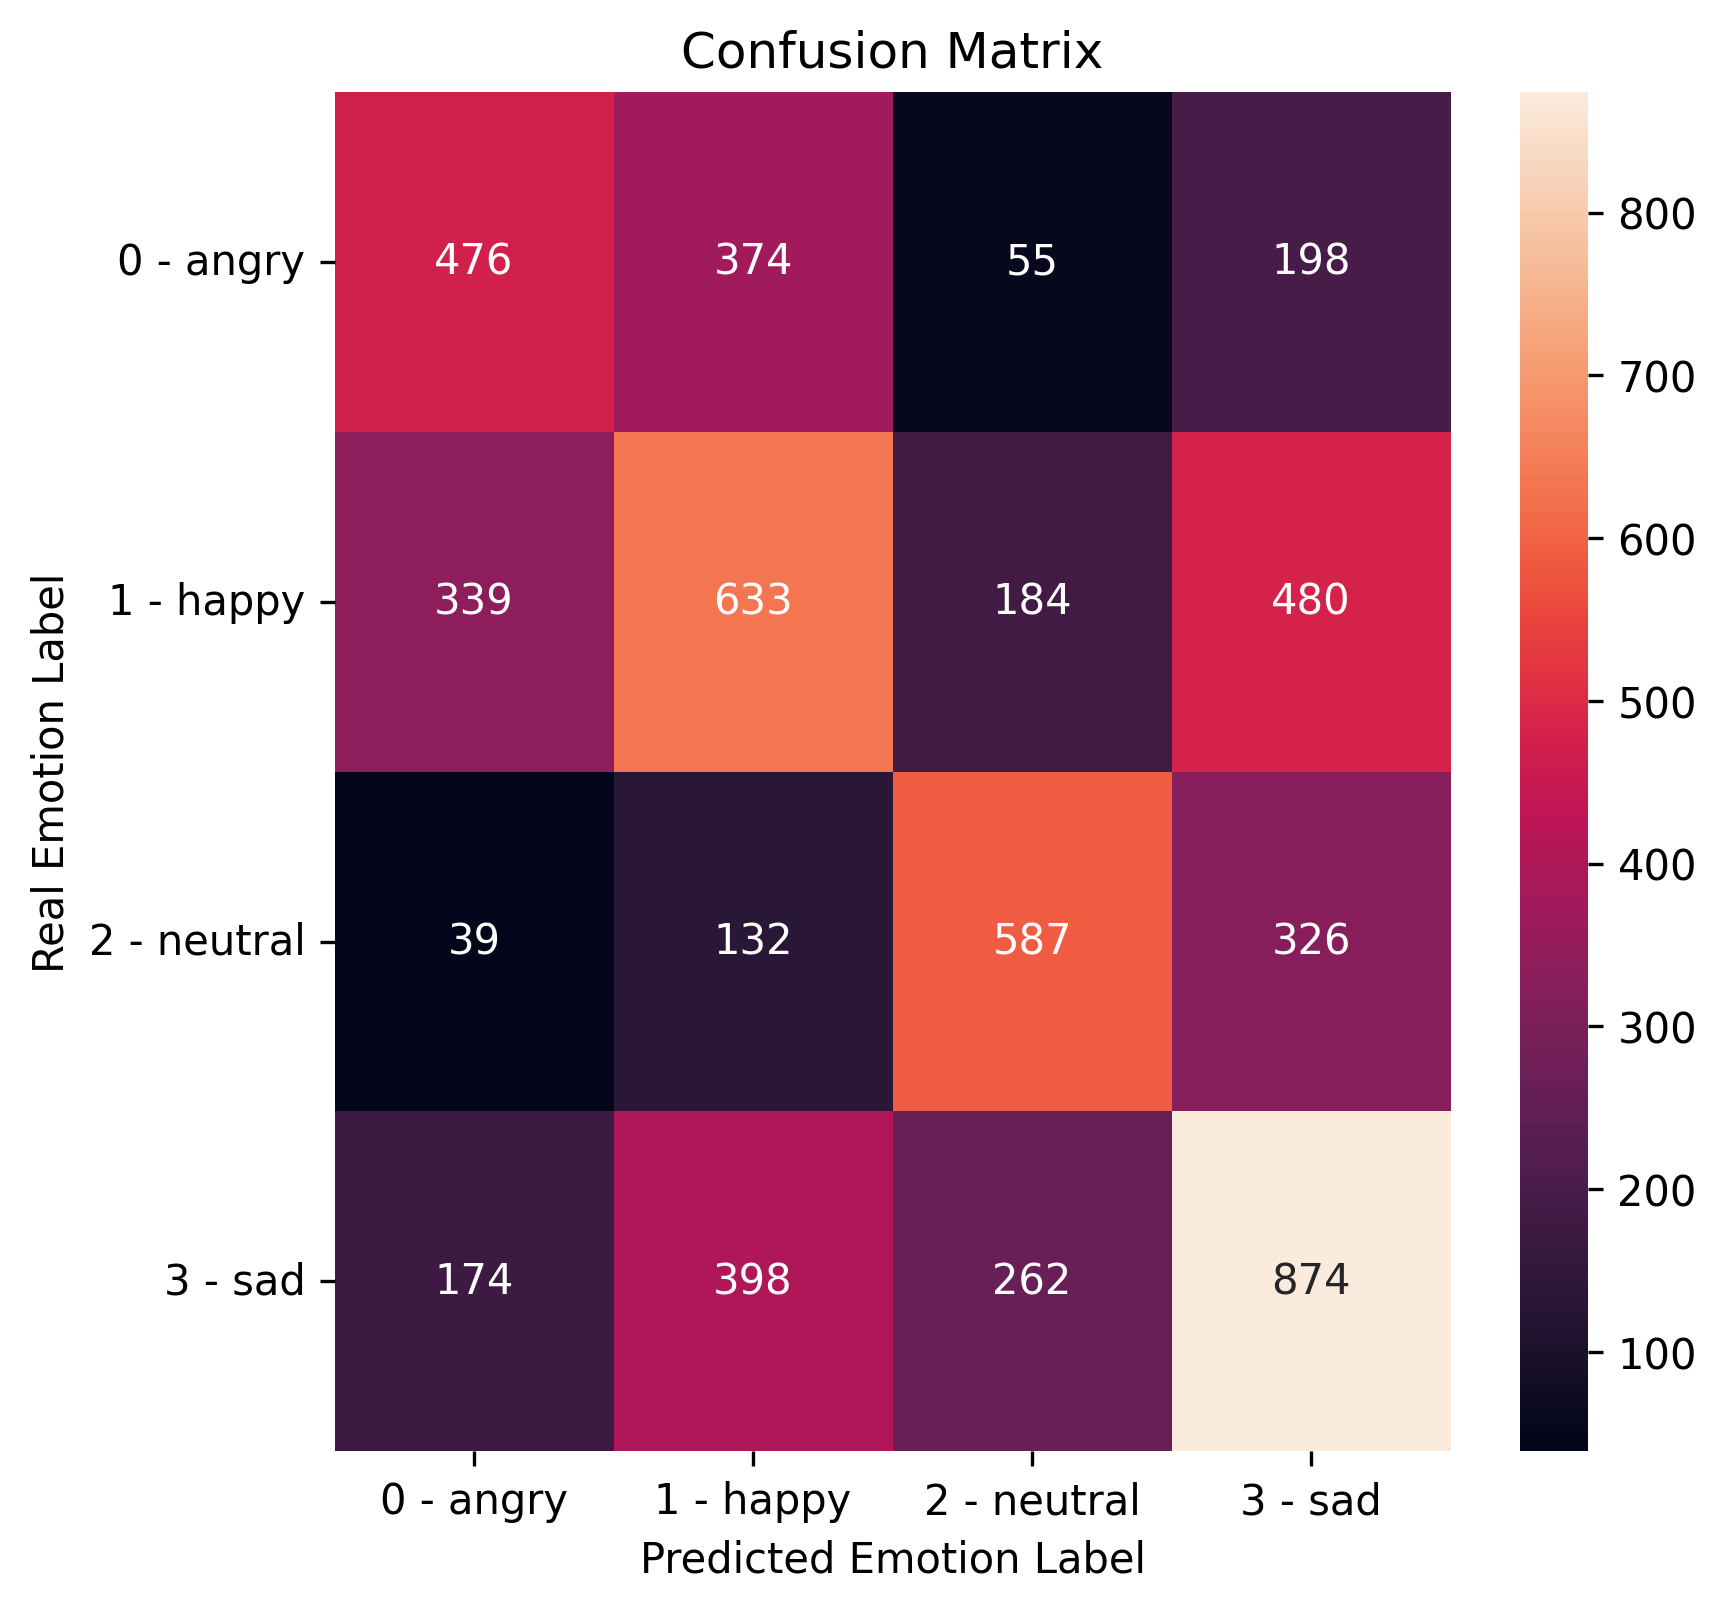

In [10]:
def get_spec_and_label(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))
    filename = audio_file.split('\\')[-1][:-4]

    with open(f'{AUDIO_SPECTOGRAMS_DIR}{filename}-mfcc.pickle', 'rb') as f:
        y = pickle.load(f)

    # for windows
    return y, spec_df.loc[f"/Users/mario/{audio_file[15:]}".replace("\\", "/")]["Emotion_Id"]
    # for linux
    # return mel_spect, spec_df.loc[audio_file]["Emotion_Id"]


def get_spec_and_label_oneHot(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))
    filename = audio_file.split('\\')[-1][:-4]

    with open(f'{AUDIO_SPECTOGRAMS_DIR}{filename}-mfcc.pickle', 'rb') as f:
        y = pickle.load(f)

    # for windows
    return y, OneHotEncodingConfig[str(spec_df.loc[f"/Users/mario/{audio_file[15:]}".replace("\\", "/")]["Emotion_Id"])]
    # for linux
    # return mel_spect, OneHotEncodingConfig[str(spec_df.loc[audio_file]["Emotion_Id"])]

y_labels = categorical_cross_validation(
    get_new_model, callback, no_epochs, batch_size, 0, num_folds)
all_y_labels, all_y_pred = y_labels
get_metrics(all_y_labels, all_y_pred, True)

## Mel-Spectrogram as a Feature

In [14]:
def categorical_cross_validation(get_new_model, callback, no_epochs, batch_size, verbosity, num_folds):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)

  all_y_pred = []
  all_y_labels = []

  X = spec_df.iloc[:]
  y = spec_df.iloc[:, 4:5]

  fold_no = 1
  for train, test in kfold.split(X, y):
    model = get_new_model()

    train_ds = X.iloc[train]
    train_ds = preprocess_dataset(train_ds)
    train_ds = train_ds.batch(64)
    train_ds = train_ds.cache().prefetch(AUTOTUNE)

    print(f'Training for fold {fold_no} ...')

    model.fit(train_ds,
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              callbacks=[callback],
              workers=8)

    test_ds = X.iloc[test]
    test_ds = preprocess_dataset(test_ds, True)
    test_ds = test_ds.batch(64)
    test_ds = test_ds.cache().prefetch(AUTOTUNE)

    for spec, label in test_ds.take(len(test_ds)):
      y_pred = model.predict(spec.numpy())
      predicted = [list(x).index(max(x)) for x in y_pred]
      real = [list(x).index(max(x)) for x in label.numpy()]
      all_y_pred.extend(predicted)
      all_y_labels.extend(real)
      

    fold_no = fold_no + 1

  return all_y_labels, all_y_pred

def get_spec_and_label(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))
    filename = audio_file.split('\\')[-1][:-4]

    with open(f'{AUDIO_SPECTOGRAMS_DIR}{filename}-mel.pickle', 'rb') as f:
        y = pickle.load(f)

    # for windows
    return y, spec_df.loc[f"/Users/mario/{audio_file[15:]}".replace("\\", "/")]["Emotion_Id"]
    # for linux
    # return mel_spect, spec_df.loc[audio_file]["Emotion_Id"]

def get_spec_and_label_oneHot(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))
    filename = audio_file.split('\\')[-1][:-4]

    with open(f'{AUDIO_SPECTOGRAMS_DIR}{filename}-mel.pickle', 'rb') as f:
        y = pickle.load(f)

    # for windows
    return y, OneHotEncodingConfig[str(spec_df.loc[f"/Users/mario/{audio_file[15:]}".replace("\\", "/")]["Emotion_Id"])]
    # for linux
    # return mel_spect, OneHotEncodingConfig[str(spec_df.loc[audio_file]["Emotion_Id"])]

y_labels = categorical_cross_validation(
    get_new_model, callback, no_epochs, batch_size, 0, num_folds)
all_y_labels, all_y_pred = y_labels
get_metrics(all_y_labels, all_y_pred, True)

Training for fold 1 ...
Training for fold 2 ...
Training for fold 3 ...
Training for fold 4 ...
Training for fold 5 ...


ValueError: Found input variables with inconsistent numbers of samples: [5531, 0]

## Spectrogram image as a Feature

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
spec_df = pd.read_csv(RAW_AUDIO_FILES)
spec_df = spec_df.set_index('File')
spec_df = spec_df[spec_df['Emotion'].isin(
    {'angry', 'neutral', 'sad', 'happy', 'excited'})]
spec_df.loc[spec_df['Emotion'] == 'excited', 'Emotion'] = 'happy'
spec_df.loc[spec_df['Emotion_Id'] == 5, 'Emotion_Id'] = 1


def get_spec_and_label(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))
    filename = audio_file.split('\\')[-1][:-4]

    spec = np.array(Image.open(f'{AUDIO_SPECTOGRAMS_DIR}{filename}.png'))
    spec = np.resize(spec, (256, 256, 3))
    spec = spec.astype('float32')
    spec /= 255

    # for windows
    return spec, spec_df.loc[f"/Users/mario/{audio_file[15:]}".replace("\\", "/")]["Emotion_Id"]
    # for linux
    # return mel_spect, spec_df.loc[audio_file]["Emotion_Id"]


def get_spec_and_label_oneHot(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))
    filename = audio_file.split('\\')[-1][:-4]

    spec = np.array(Image.open(f'{AUDIO_SPECTOGRAMS_DIR}{filename}.png'))
    spec = np.resize(spec, (256, 256, 3))
    spec = spec.astype('float32')
    spec /= 255

    # for windows
    return spec, OneHotEncodingConfig[str(spec_df.loc[f"/Users/mario/{audio_file[15:]}".replace("\\", "/")]["Emotion_Id"])]
    # for linux
    # return mel_spect, OneHotEncodingConfig[str(spec_df.loc[audio_file]["Emotion_Id"])]


def data_loader(filename):
    features, labels = tf.py_function(
        get_spec_and_label, [filename], [tf.float32, tf.int64])
    return tf.reshape(features, [256, 256, 3]), tf.reshape(labels, [1])


def data_loader_oneHot(filename):
    features, labels = tf.py_function(
        get_spec_and_label_oneHot, [filename], [tf.float32, tf.float32])
    return tf.reshape(features, [256, 256, 3]), tf.reshape(labels, [4])


def preprocess_dataset(files, oneHotEncoding=False):
  # mac
    #   filenames_ds = tf.data.Dataset.list_files([str(file) for file in files.index.values])
  # windows
  filenames_ds = tf.data.Dataset.list_files(
      [f"C:\\Users\\Chico{str(file)[12:]}" for file in files.index.values])
  if oneHotEncoding:
    return filenames_ds.map(data_loader_oneHot, num_parallel_calls=AUTOTUNE)

  return filenames_ds.map(data_loader, num_parallel_calls=AUTOTUNE)


In [4]:
def build_model_2(input_shape, loss, optimizer):
    model = Sequential()
    model.add(Conv2D(16, (7, 7), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (5, 5), strides=(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dropout(0.25))
    model.add(Dense(4))
    model.add(Activation('softmax'))
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model


def get_new_model():
    input_shape = (256, 256, 3)
    learning_rate = 1e-3
    loss = SparseCategoricalCrossentropy()
    optimizer = Adam(learning_rate=learning_rate)
    return build_model_2(input_shape, loss, optimizer)


get_new_model().summary(show_trainable=True)


Model: "sequential"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv2d (Conv2D)             (None, 128, 128, 16)      2368      Y          
                                                                            
 activation (Activation)     (None, 128, 128, 16)      0         Y          
                                                                            
 batch_normalization (BatchN  (None, 128, 128, 16)     64        Y          
 ormalization)                                                              
                                                                            
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        12832     Y          
                                                                            
 activation_1 (Activation)   (None, 64, 64, 32)        0         Y          
                                                        

In [5]:
def categorical_cross_validation(get_new_model, callback, no_epochs, batch_size, verbosity, num_folds):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)

  all_y_pred = []
  all_y_labels = []

  X = spec_df.iloc[:]
  y = spec_df.iloc[:, 4:5]

  fold_no = 1
  for train, test in kfold.split(X, y):
    model = get_new_model()

    train_ds = X.iloc[train]
    train_ds = preprocess_dataset(train_ds)
    train_ds = train_ds.batch(64)
    train_ds = train_ds.cache().prefetch(AUTOTUNE)

    print(f'Training for fold {fold_no} ...')

    model.fit(train_ds,
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              callbacks=[callback],
              workers=8)

    test_ds = X.iloc[test]
    test_ds = preprocess_dataset(test_ds, True)
    test_ds = test_ds.batch(64)
    test_ds = test_ds.cache().prefetch(AUTOTUNE)

    for spec, label in test_ds.take(len(test_ds)):
      y_pred = model.predict(spec.numpy())
      all_y_pred.extend([list(x).index(max(x)) for x in y_pred])
      all_y_labels.extend([list(x).index(max(x)) for x in label.numpy()])

    fold_no = fold_no + 1

  return all_y_labels, all_y_pred

callback = EarlyStopping(monitor='loss', patience=10)
no_epochs = 50
batch_size = 64

verbosity = 1
num_folds = 5

y_labels = categorical_cross_validation(
    get_new_model, callback, no_epochs, batch_size, verbosity, num_folds)


Training for fold 1 ...
Epoch 1/50
70/70 [==============================] - 28s 388ms/step - loss: 1.7691 - accuracy: 0.3773
Epoch 2/50
70/70 [==============================] - 25s 356ms/step - loss: 1.3360 - accuracy: 0.4448
Epoch 3/50
70/70 [==============================] - 25s 355ms/step - loss: 1.2391 - accuracy: 0.4706
Epoch 4/50
70/70 [==============================] - 25s 357ms/step - loss: 1.1216 - accuracy: 0.5206
Epoch 5/50
70/70 [==============================] - 25s 356ms/step - loss: 1.0126 - accuracy: 0.5748
Epoch 6/50
70/70 [==============================] - 25s 356ms/step - loss: 0.9126 - accuracy: 0.6169
Epoch 7/50
70/70 [==============================] - 25s 354ms/step - loss: 0.8289 - accuracy: 0.6542
Epoch 8/50
70/70 [==============================] - 25s 356ms/step - loss: 0.7486 - accuracy: 0.6872
Epoch 9/50
70/70 [==============================] - 25s 355ms/step - loss: 0.6622 - accuracy: 0.7285
Epoch 10/50
70/70 [==============================] - 25s 355ms/step

Metric               Value
-----------------  -------
Accuracy            52.07
F1 score macro      52.69
Precision           52.88
Recall              52.68
Matthews corrcoef    0.351


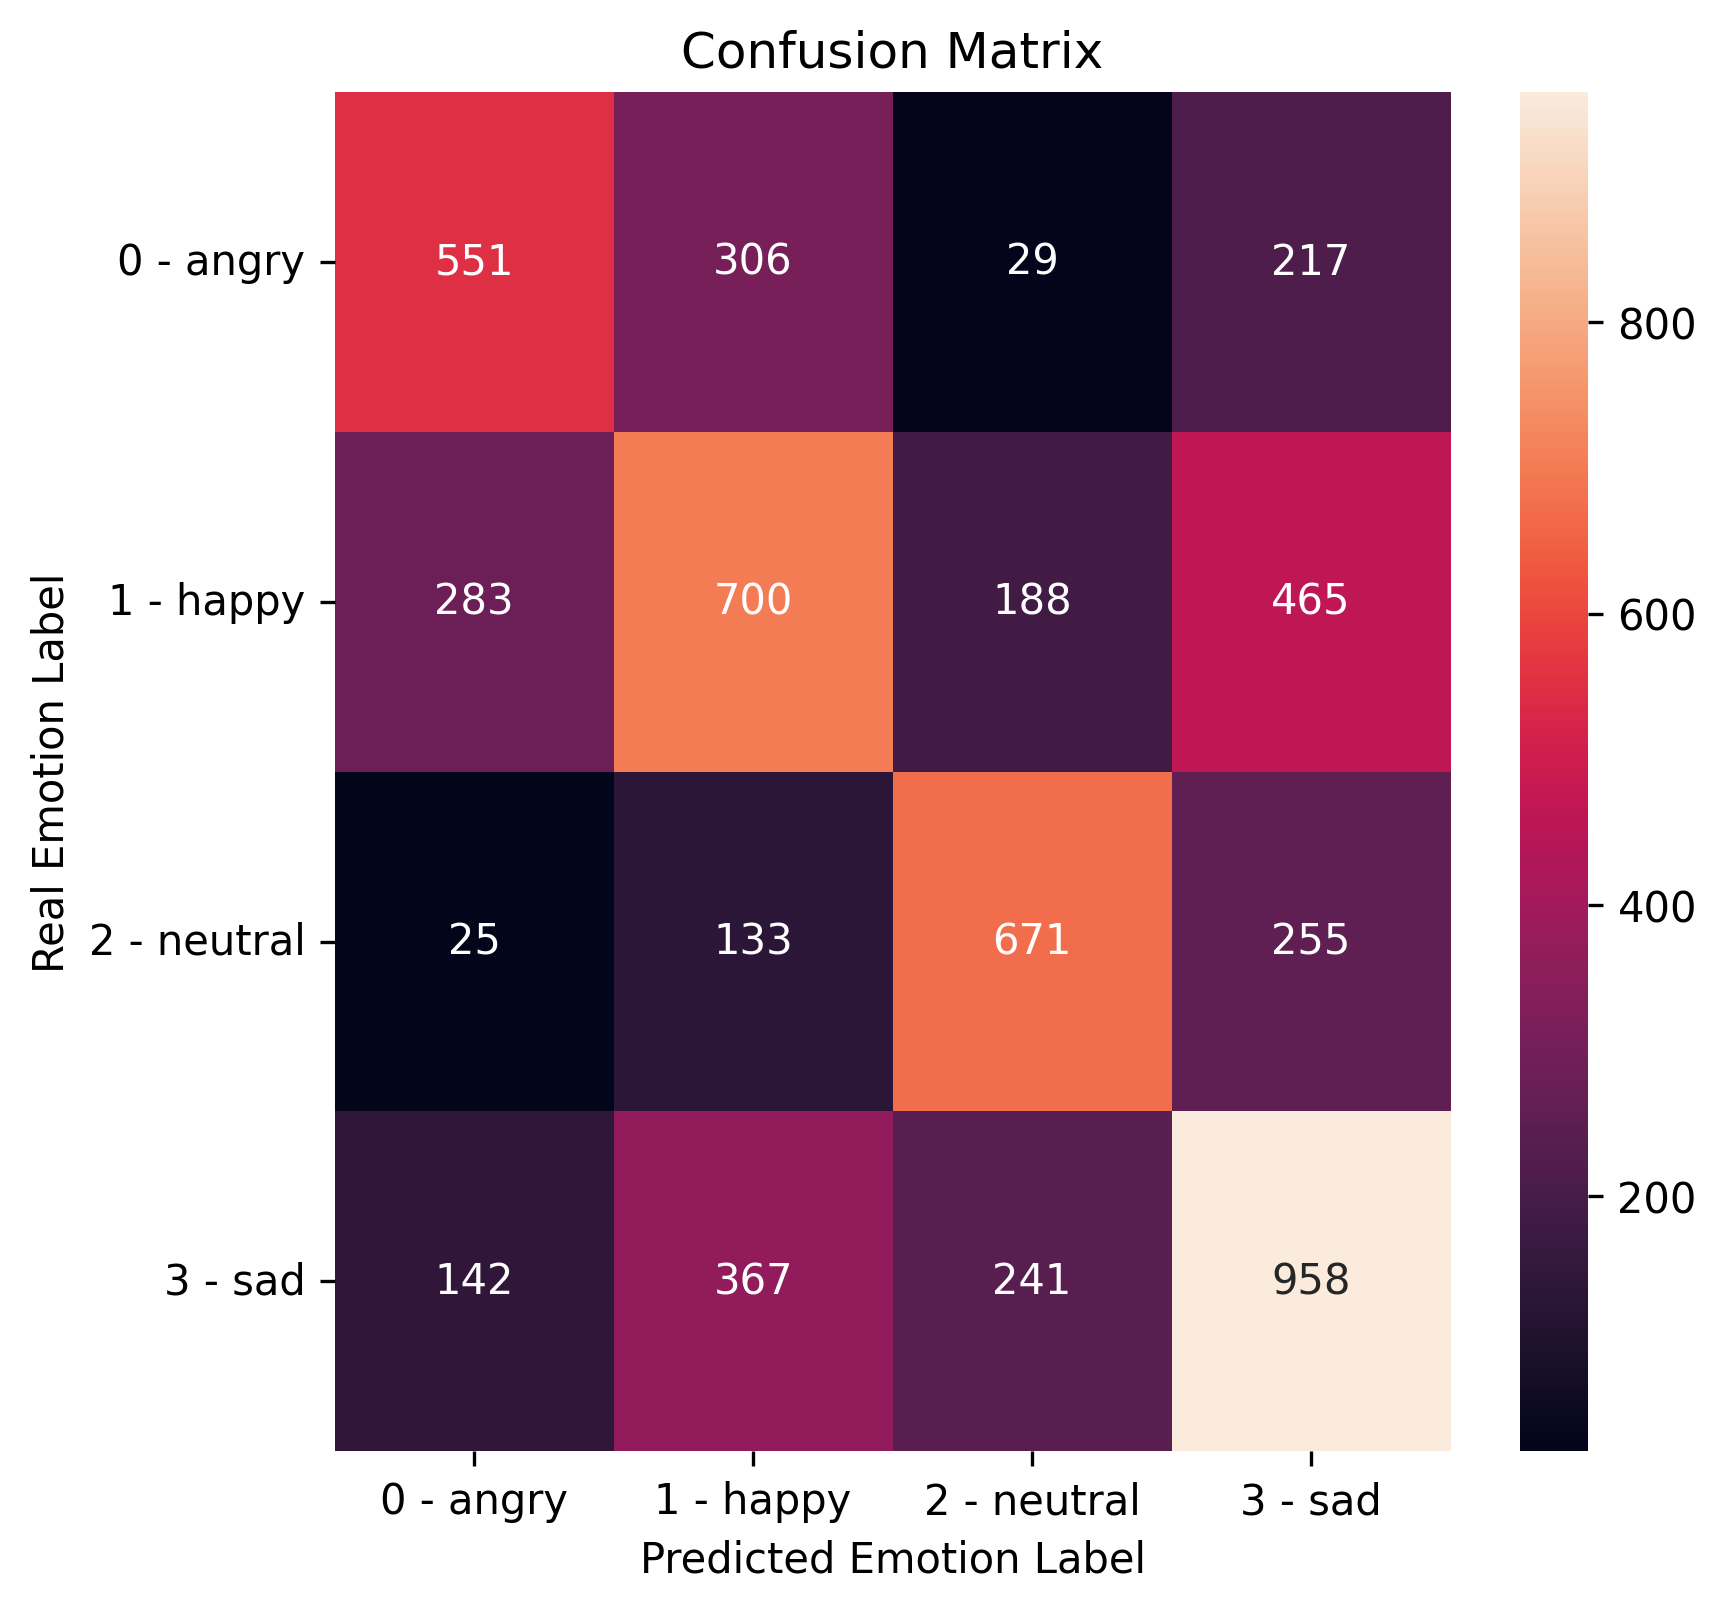

In [6]:
all_y_labels, all_y_pred = y_labels
get_metrics(all_y_labels, all_y_pred, True)

AlexNet Transfer Learning

In [7]:
def build_alexNet_model(input_shape, loss, optimizer):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(
            4, 4), activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
        tf.keras.layers.Conv2D(filters=256, kernel_size=(
            5, 5), strides=(1, 1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
        tf.keras.layers.Conv2D(filters=384, kernel_size=(
            3, 3), strides=(1, 1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=384, kernel_size=(
            3, 3), strides=(1, 1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=256, kernel_size=(
            3, 3), strides=(1, 1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model


def get_new_model():
    input_shape = (256, 256, 3)
    learning_rate = 0.001
    loss = SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    return build_alexNet_model(input_shape, loss, optimizer)


y_labels = categorical_cross_validation(
    get_new_model, callback, no_epochs, batch_size, verbosity, num_folds)


Training for fold 1 ...
Epoch 1/50
39/70 [===============>..............] - ETA: 48s - loss: 2.6765 - accuracy: 0.2688

KeyboardInterrupt: 

In [ ]:
all_y_labels, all_y_pred = y_labels
get_metrics(all_y_labels, all_y_pred, True)

## Results

In [35]:
headers = ["Model", "Input Size", "Accuracy", "Macro F1", "Micro F1", "Precision", "Recall", "MCC."]

results = [
    ["Random Forest", 24, 0.5876, 0.5957, 0.5876, 0.6038, 0.5918, 0.4410],
    ["Linear Discriminant Analysis", 24, 0.5588, 0.5683, 0.5588, 0.5700, 0.5687, 0.4033],
    ["Histogram Gradient Boosting", 24, 0.6010, 0.6091, 0.6010, 0.6140, 0.6066, 0.4603],
    ["AutoSK Ensemble", 24, 0.6035, 0.6120, 0.6035, 0.6174, 0.6114, 0.4642],
    ["Simple CNN", 24, 0.4562, 0.4622, 0.4562, 0.4856, 0.4613, 0.2649],
    ["AutoKeras NN", 24, 0.4280, 0.4206, 0.4280, 0.4783, 0.4083, 0.2109],
    ["AutoKeras NN", 5024, 0.4681, 0.4680, 0.46812, 0.4724, 0.4696, 0.2813],
    ["AutoKeras NN", 5048, 0.5050, 0.5085, 0.5050, 0.5078, 0.5192, 0.3361],
]

print(tabulate(results, headers=headers, tablefmt="github"))

| Model                        |   Input Size |   Accuracy |   Macro F1 |   Micro F1 |   Precision |   Recall |   MCC. |
|------------------------------|--------------|------------|------------|------------|-------------|----------|--------|
| Random Forest                |           24 |     0.5876 |     0.5957 |    0.5876  |      0.6038 |   0.5918 | 0.441  |
| Linear Discriminant Analysis |           24 |     0.5588 |     0.5683 |    0.5588  |      0.57   |   0.5687 | 0.4033 |
| Histogram Gradient Boosting  |           24 |     0.601  |     0.6091 |    0.601   |      0.614  |   0.6066 | 0.4603 |
| AutoSK Ensemble              |           24 |     0.6035 |     0.612  |    0.6035  |      0.6174 |   0.6114 | 0.4642 |
| Simple CNN                   |           24 |     0.4562 |     0.4622 |    0.4562  |      0.4856 |   0.4613 | 0.2649 |
| AutoKeras NN                 |           24 |     0.428  |     0.4206 |    0.428   |      0.4783 |   0.4083 | 0.2109 |
| AutoKeras NN                 |